# Using Data Science for Bad Decision-Making

You will probably be intrigued by the title of this post. In this notebook I do not want to present a fancy data science trick or to test a novel technique. I would simply like to tell a story. A story about how data science can be used to make bad decisions. "How can this be?" you might ask. Everyone has been saying that data is the way to unlock insights to gain a competitive advantage. Well, it is true. But it is also true that data can be used to make decisions that can actually hurt your business. There are many possible reasons you could think of (and you might even have experienced some of them). The story I am about to tell won't be about bad algorithms or bad data. It will be about thinking about data as simply

$$
\text{data in} \rightarrow \text{ML model} \rightarrow \text{data out} \rightarrow \text{decision}
$$

instead of thinking about the data generating process. In other words, it will be about not thinking about **causality**. 

### The Business Problem

The story begins in a fast paced startup. The company is growing fast and the marketing team is looking for ways to increase the sales from existing customers by making them buy more. The main idea is to unlock the potential of the customer based through incentives, in this case a discount. We of course want to measure the effect of the discount on the customer's behavior. Still, they do not want to waste money giving discounts to users which are not valuable. As always, it is about return on investment (ROI). Without going into specifics about the nature of the discount, it has been designed to provide a positive return on investment if the customer buys more than $1\$$ as a result of the discount. How can we measure the effect of the discount and make sure our experiment has a positive ROI? The marketing team came up with the following strategy:

- Select a sample of existing customers from the same cohort.
- Set a test window of 1 month.
- Look into the historical data of web visits from the last month. The hypothesis is that web visits are a good proxy for the customer's interest in the product.
- For customers with a high number of web visits, send them a discount. There will be a hold out group which will not receive the discount within the potential valuable customers based on the number of web visits. For customers with a low number of web visits, do not send them a discount (the marketing team wants to report a positive ROI, so they do not want to waste money on customers which are not valuable). Still, they want to use them to measure the effect of the discount.
- We also want to use the results of the test to tag *loyal* customers. These are customers which got a discount (since they showed potential interest in the product) and customers with exceptional sales numbers even if they did not get a discount. The idea is to use this information to target them in the future if the discount strategy is positive.

### The Data

The team collected data from the experiment above and asked the data science team to analyze it and provide insights. In particular they want to know if they should keep the discount strategy. The data consists of the following fields:
- `visits`: Number of visits to the website during the test window.
- `discount`: Whether the customer received a discount or not.
- `is_loyal`: Whether the customer is loyal or not according to the definition above.
- `sales`: Sales in $\$$ during the test window.

### The Analysis

Now that the context, objectives and data are clear, let's look into the story about a relatively innocent analysis which turn out to be a pain and whose outcome and final decision was not the best one. But hey, do not worry, we will learn from it!

---

# Part 1: The Analysis Story

On this first part we describe the story behind the discount analysis by the data science team.

## Prepare Notebook

Data scientist A was the one in charge of preparing the environment and collecting the data. As an important best practice, they fixed a global seed in order to make sure every part of the analysis was reproducible so that the outcomes are not affected by pure randomness. In addition all the required packages were listed from the start (reproducible python environment).

In [1]:
import arviz as az
import bambi as bmb
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "causality"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Read Data

They pulled the data from a csv file.

In [3]:
data = pd.read_csv("../data/sales_dag.csv")

data.head()


visits  discount  is_loyal      sales  sales_per_visit
0      12         0         0  13.348302         1.112359
1      26         1         1  21.701250         0.834663
2      13         0         0  14.700405         1.130800
3      24         0         0  20.377336         0.849056
4      14         0         0  12.633725         0.902409

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   visits           700 non-null    int64  
 1   discount         700 non-null    int64  
 2   is_loyal         700 non-null    int64  
 3   sales            700 non-null    float64
 4   sales_per_visit  700 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 27.5 KB


No missing values and features seem to be in the correct format.

## Exploratory Data Analysis

As part of the project scope, the data science team in charge of the analysis was asked to provide a summary of the data. The team was also asked to provide a visualization of the data to help the marketing team understand the data better. Data scientist A took over this task. They started by looking at the share of customers which received a discount:

In [5]:
data["discount"].value_counts() / len(data)

discount
1    0.74
0    0.26
Name: count, dtype: float64

Similarly for the share of customers which are loyal:

In [6]:
data["is_loyal"].value_counts() / len(data)

is_loyal
1    0.75
0    0.25
Name: count, dtype: float64

To understand these features better, they also looked at a cross-tab table:

In [7]:
pd.crosstab(data["discount"], data["is_loyal"])

is_loyal    0    1
discount          
0         175    7
1           0  518

Note that all customers with discount are loyal (as required) and that there are loyal users which did not receive a discount. This is because they had exceptional sales numbers. Let's verify this:

In [8]:
data.query("discount == 0").sort_values(by="sales", ascending=False).head(10)


visits  discount  is_loyal      sales  sales_per_visit
566      33         0         1  31.721689         0.961263
204      33         0         1  28.311111         0.857912
365      33         0         1  28.081634         0.850959
49       33         0         1  27.790644         0.842141
280      29         0         1  27.581146         0.951074
545      27         0         1  26.255330         0.972420
104      29         0         1  26.217525         0.904053
361      28         0         0  24.094104         0.860504
651      28         0         0  24.064587         0.859450
493      27         0         0  24.006295         0.889122

The loyal customers are the top ones in terms of sales. This is good news. It means that the definition of loyal customers is consistent with the data.

In order to have orders of magnitude for the sales, the data scientist provided some summary statistics table:

In [9]:
data["sales"].describe()

count    700.000000
mean      19.400159
std        4.879144
min        2.088539
25%       16.443930
50%       19.495469
75%       22.500405
max       36.136312
Name: sales, dtype: float64

To have a better glimpse of the data, the data scientist also provided a histogram of the sales:

Text(0.5, 1.05, 'Sales Distribution')

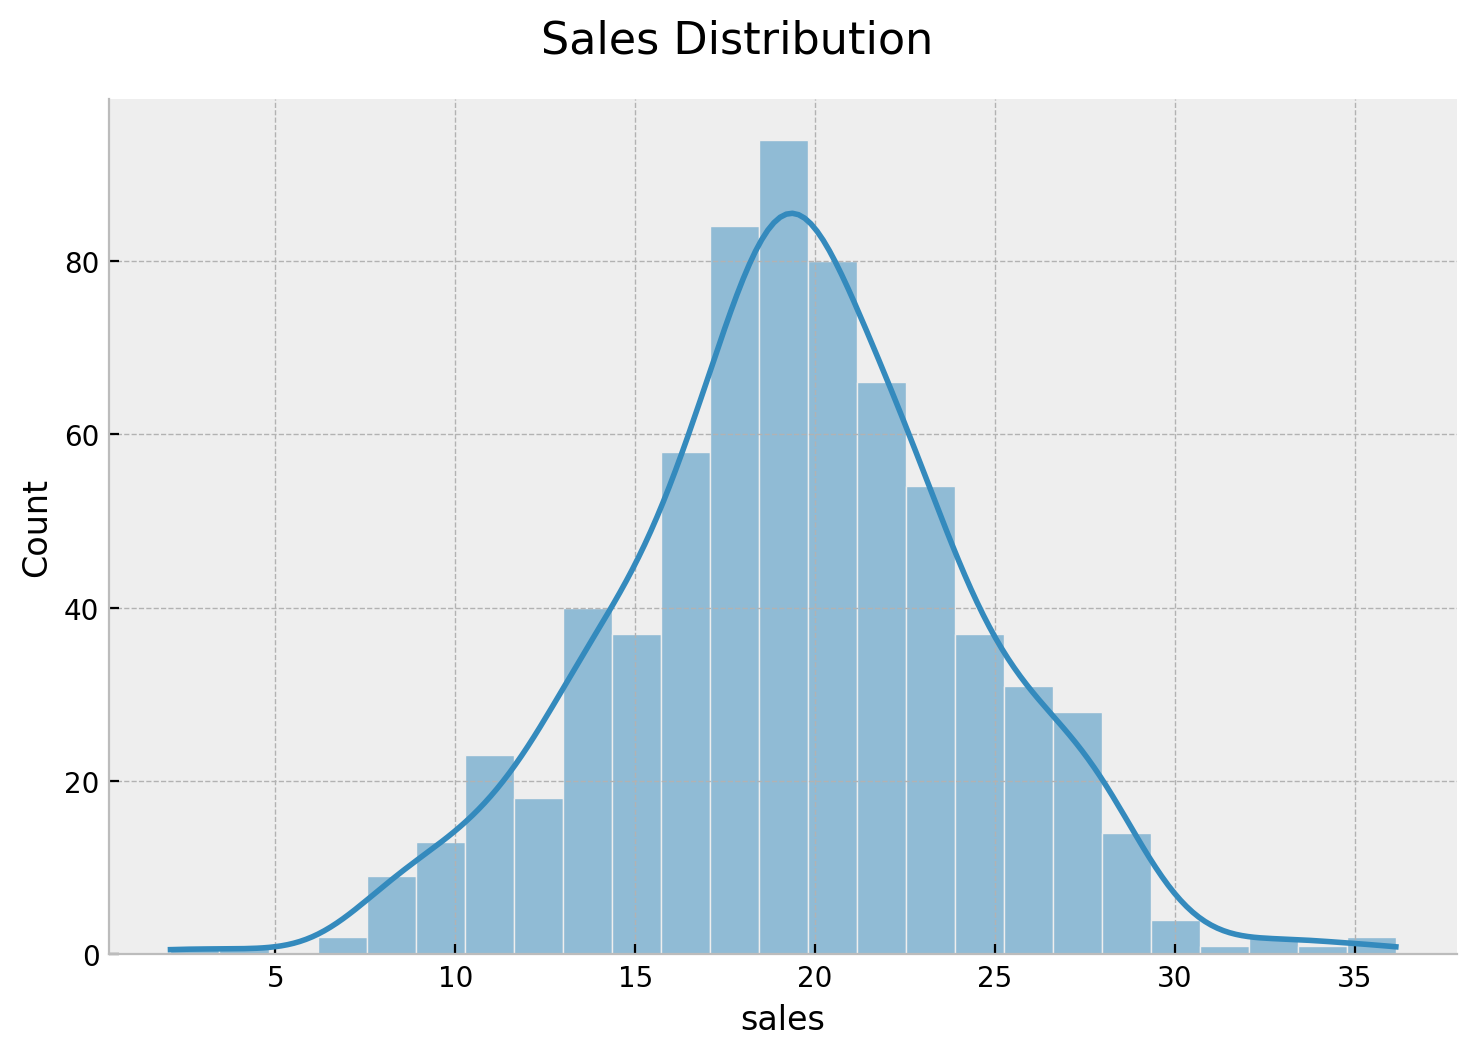

In [10]:
g = sns.displot(
    data=data, x="sales", kind="hist", kde=True, fill=True, height=5, aspect=1.5
)
g.fig.suptitle("Sales Distribution", y=1.05, fontsize=16)


## Descriptive Statistics

Data scientist A feels comfortable with the data and decides to move on to the discount analysis. The first thing they did was to split the sales distribution by discount group:

Text(0.5, 1.05, 'Sales Distribution by Discount Group')

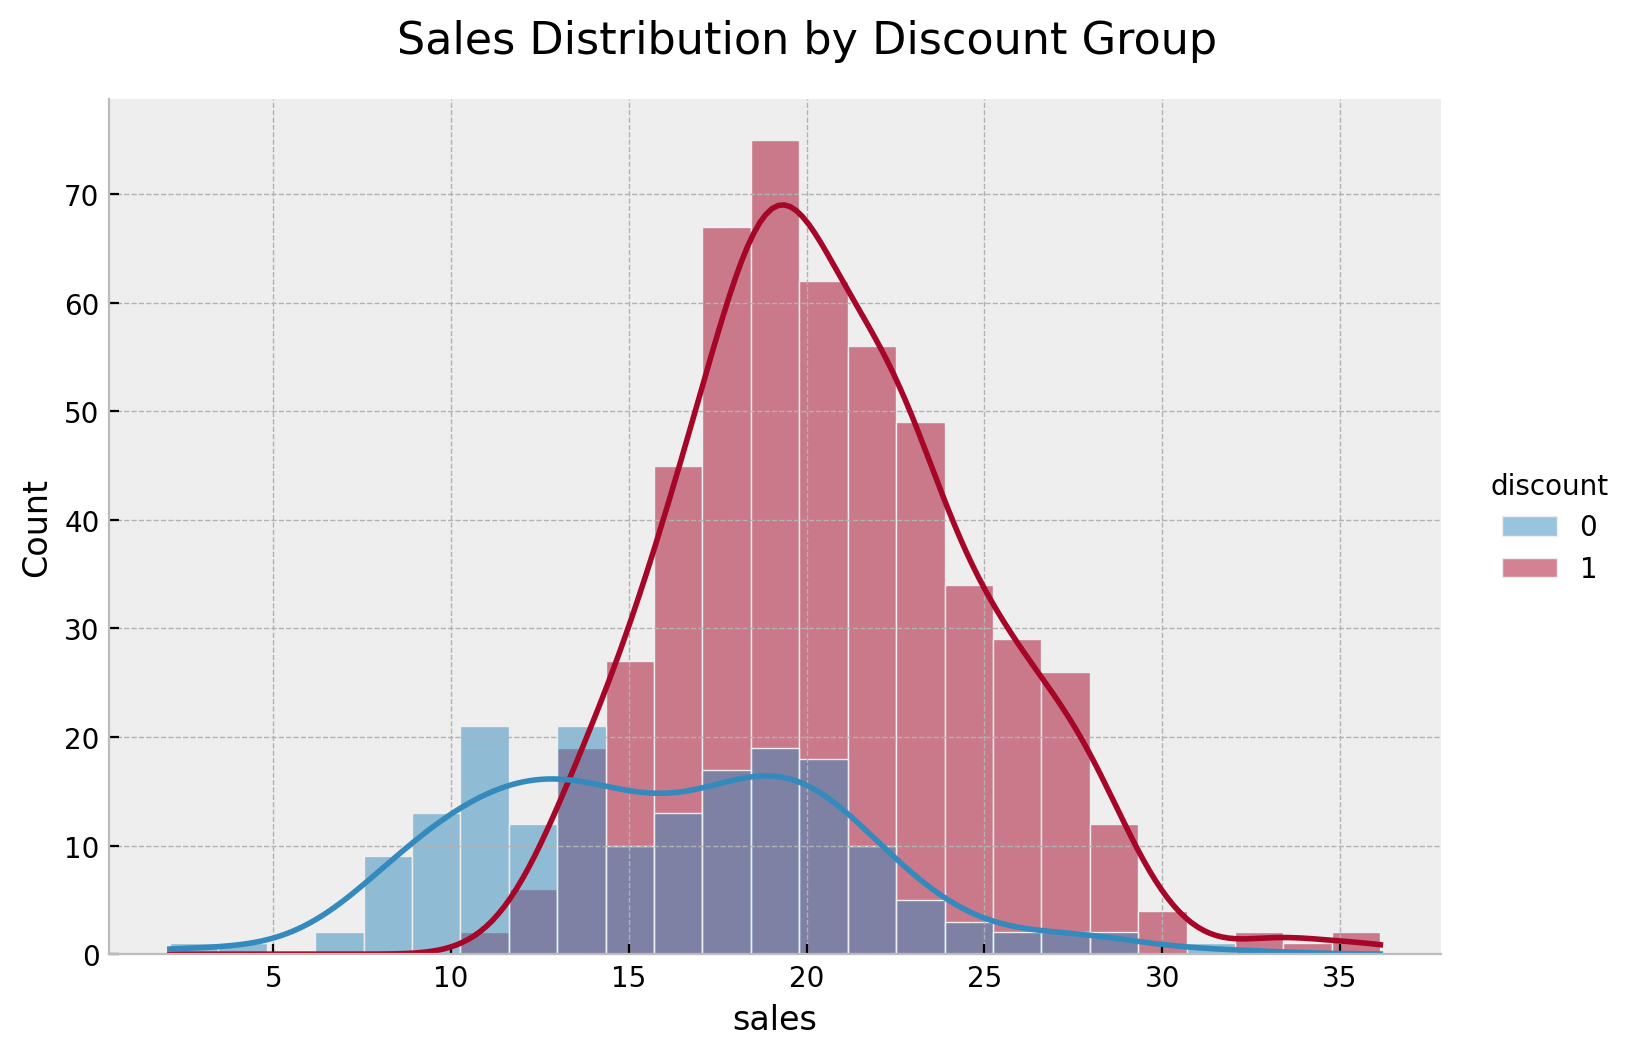

In [11]:
g = sns.displot(
    data=data,
    x="sales",
    kind="hist",
    hue="discount",
    kde=True,
    fill=True,
    height=5,
    aspect=1.5,
)
g.fig.suptitle("Sales Distribution by Discount Group", y=1.05, fontsize=16)

It looks customers with discount have higher sales. Data scientist A is optimistic with this initial result. To quantify this, they computed the difference in means:

In [12]:
data.groupby(["discount"]).agg({"sales": "mean"})


sales
discount           
0         15.848788
1         20.647938

In [13]:
(
    data.query("discount == 1")["sales"].mean()
    - data.query("discount == 0")["sales"].mean()
)

4.799150094279289

Wow! We see $4.8\$$ mean uplift! This is great news. The discount strategy seems to be working. Data scientist A is happy with the results and decides to get feedback from the rest of the data science team.

Data scientist B is not so happy with the results. They think that the uplift is too good to be true (based on domain knowledge and the sales distributions 🤔). When thinking about reasons for such a high uplift, they realized the discount assignment was not at random. It was based on the number of web visits (remember the marketing plan?). This means that the discount group is not comparable to the control group completely! They decide to plot sales against web visits per discount group:

Text(0.5, 1.05, 'Sales vs. Visits')

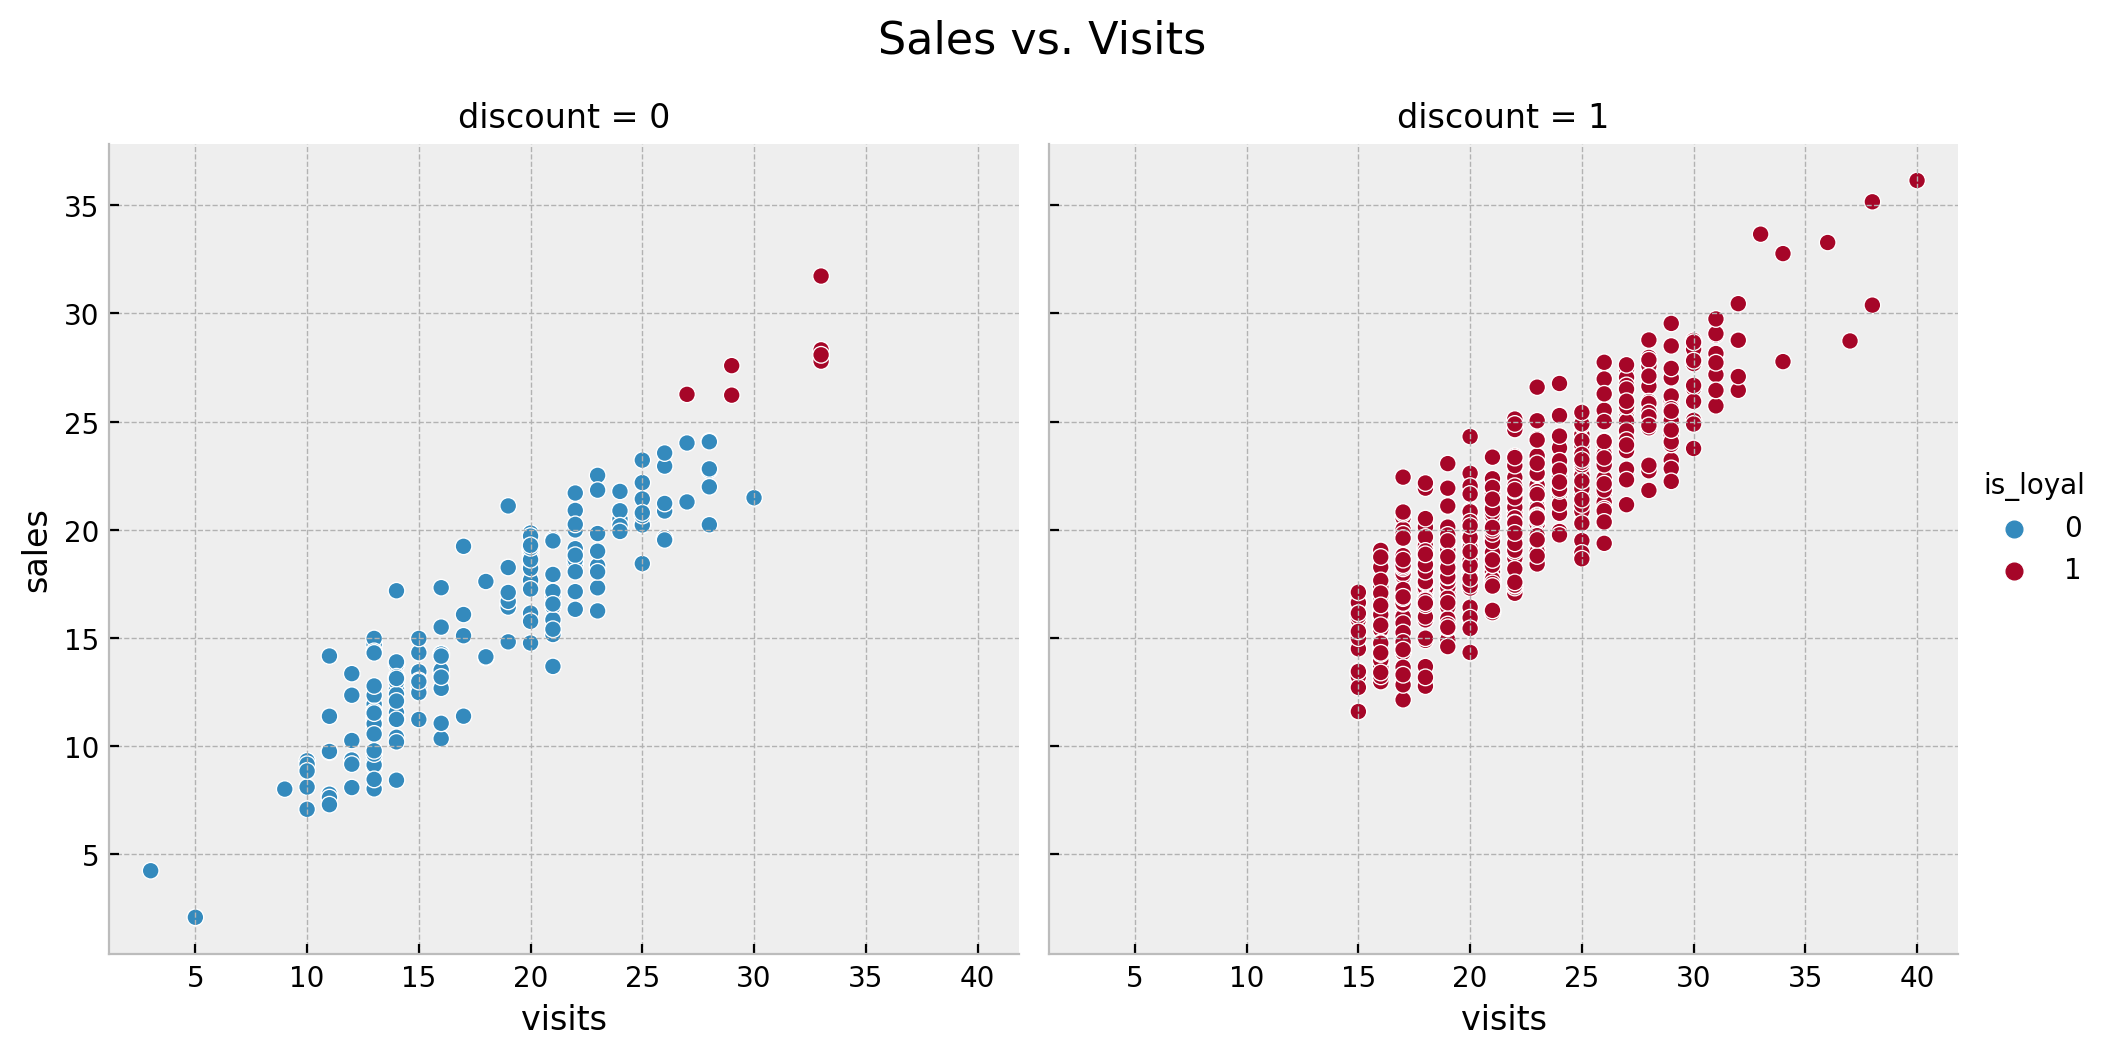

In [14]:
g = sns.relplot(data=data, x="visits", y="sales", hue="is_loyal", col="discount")
g.fig.suptitle("Sales vs. Visits", y=1.05, fontsize=16)

Indeed, they realize they should probably adjust for the number of web visits. A natural metric is sales per web visit. Let's compute it:

In [15]:
data.groupby(["discount"]).agg({"sales_per_visit": "mean"})


sales_per_visit
discount                 
0                0.861243
1                0.938293

The mean value is higher for the discount group. As always, they also looked at the distributions:

Text(0.5, 1.05, 'Sales per Web Visits Distribution by Discount Group')

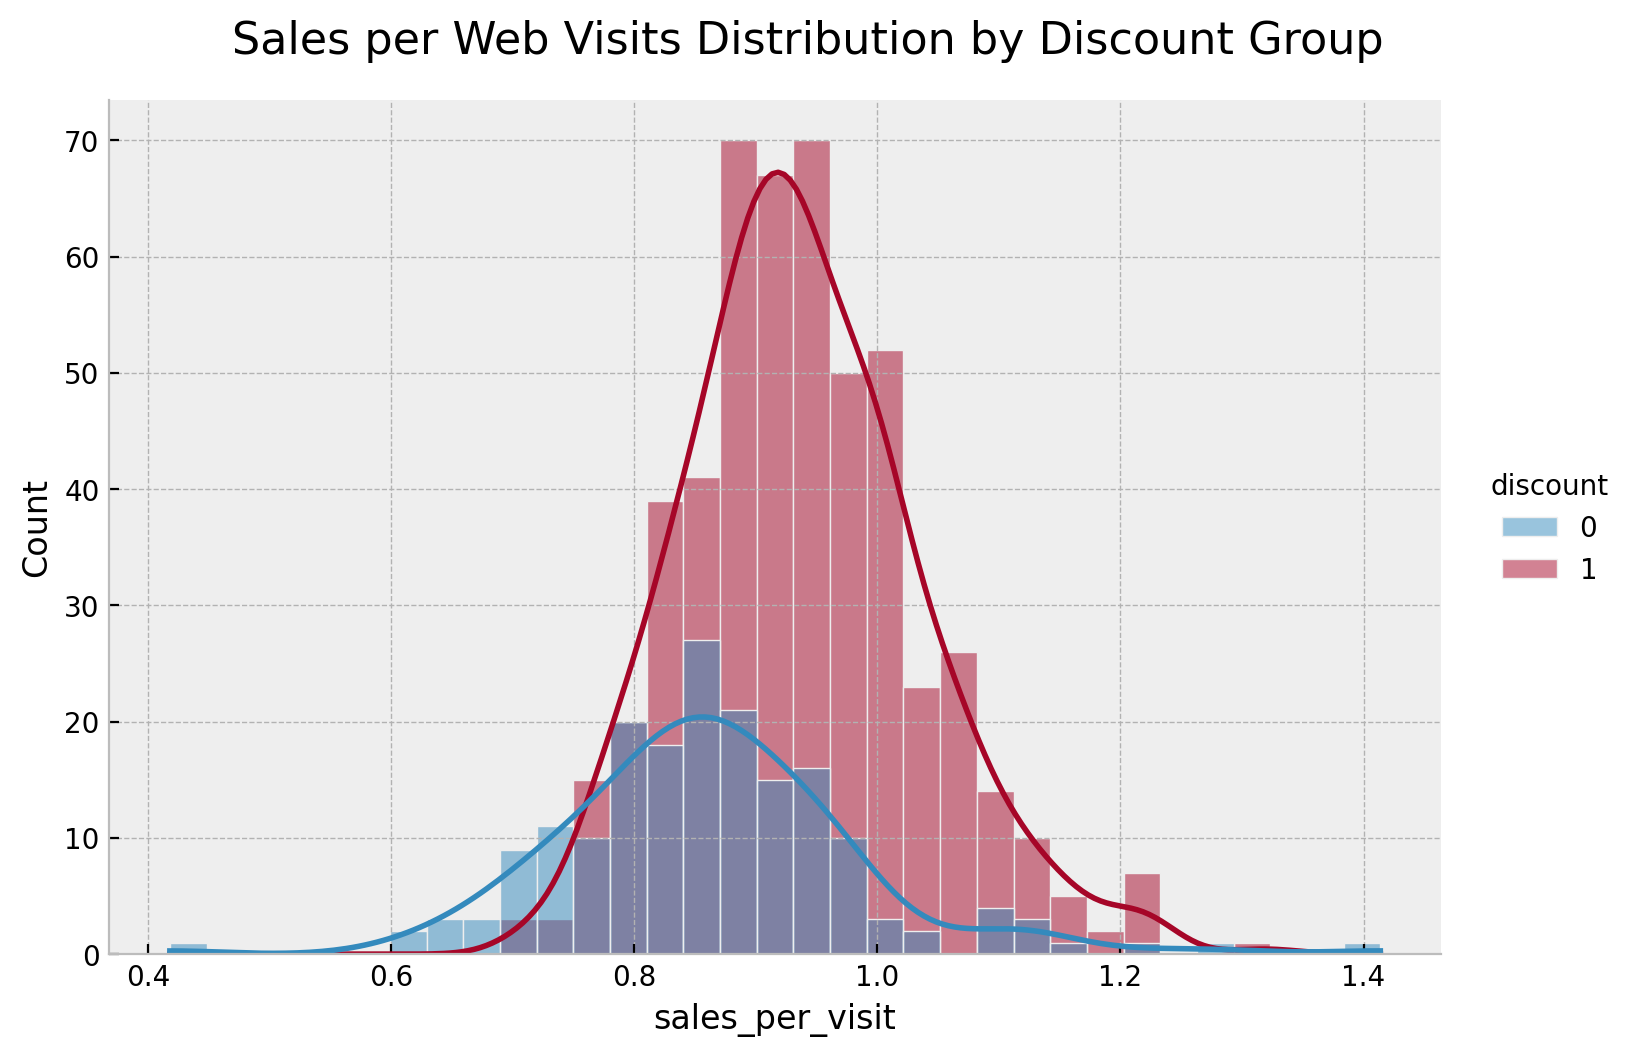

In [16]:
g = sns.displot(
    data=data,
    x="sales_per_visit",
    kind="hist",
    hue="discount",
    kde=True,
    fill=True,
    height=5,
    aspect=1.5,
)
g.fig.suptitle(
    "Sales per Web Visits Distribution by Discount Group", y=1.05, fontsize=16
)

For both data scientist the results look much better, but they were unsure about which uplift to report. They thought about the difference in means:

In [17]:
(
    data.query("discount == 1")["sales_per_visit"].mean()
    - data.query("discount == 0")["sales_per_visit"].mean()
)


0.07705031597862955

However, how to interpret this value in terms of dollars? When thinking about what and how to report to the marketing team, data scientist C came and strongly suggested to also control for loyalty as the discount strategy was designed to define (target?) loyal customers. Data scientist A and B agreed, but they were not sure about how to do this. To get some inspiration, they looked at some additional descriptive statistics and plots splitting by loyalty level.

Text(0.5, 1.05, 'Sales distribution by discount and loyalty')

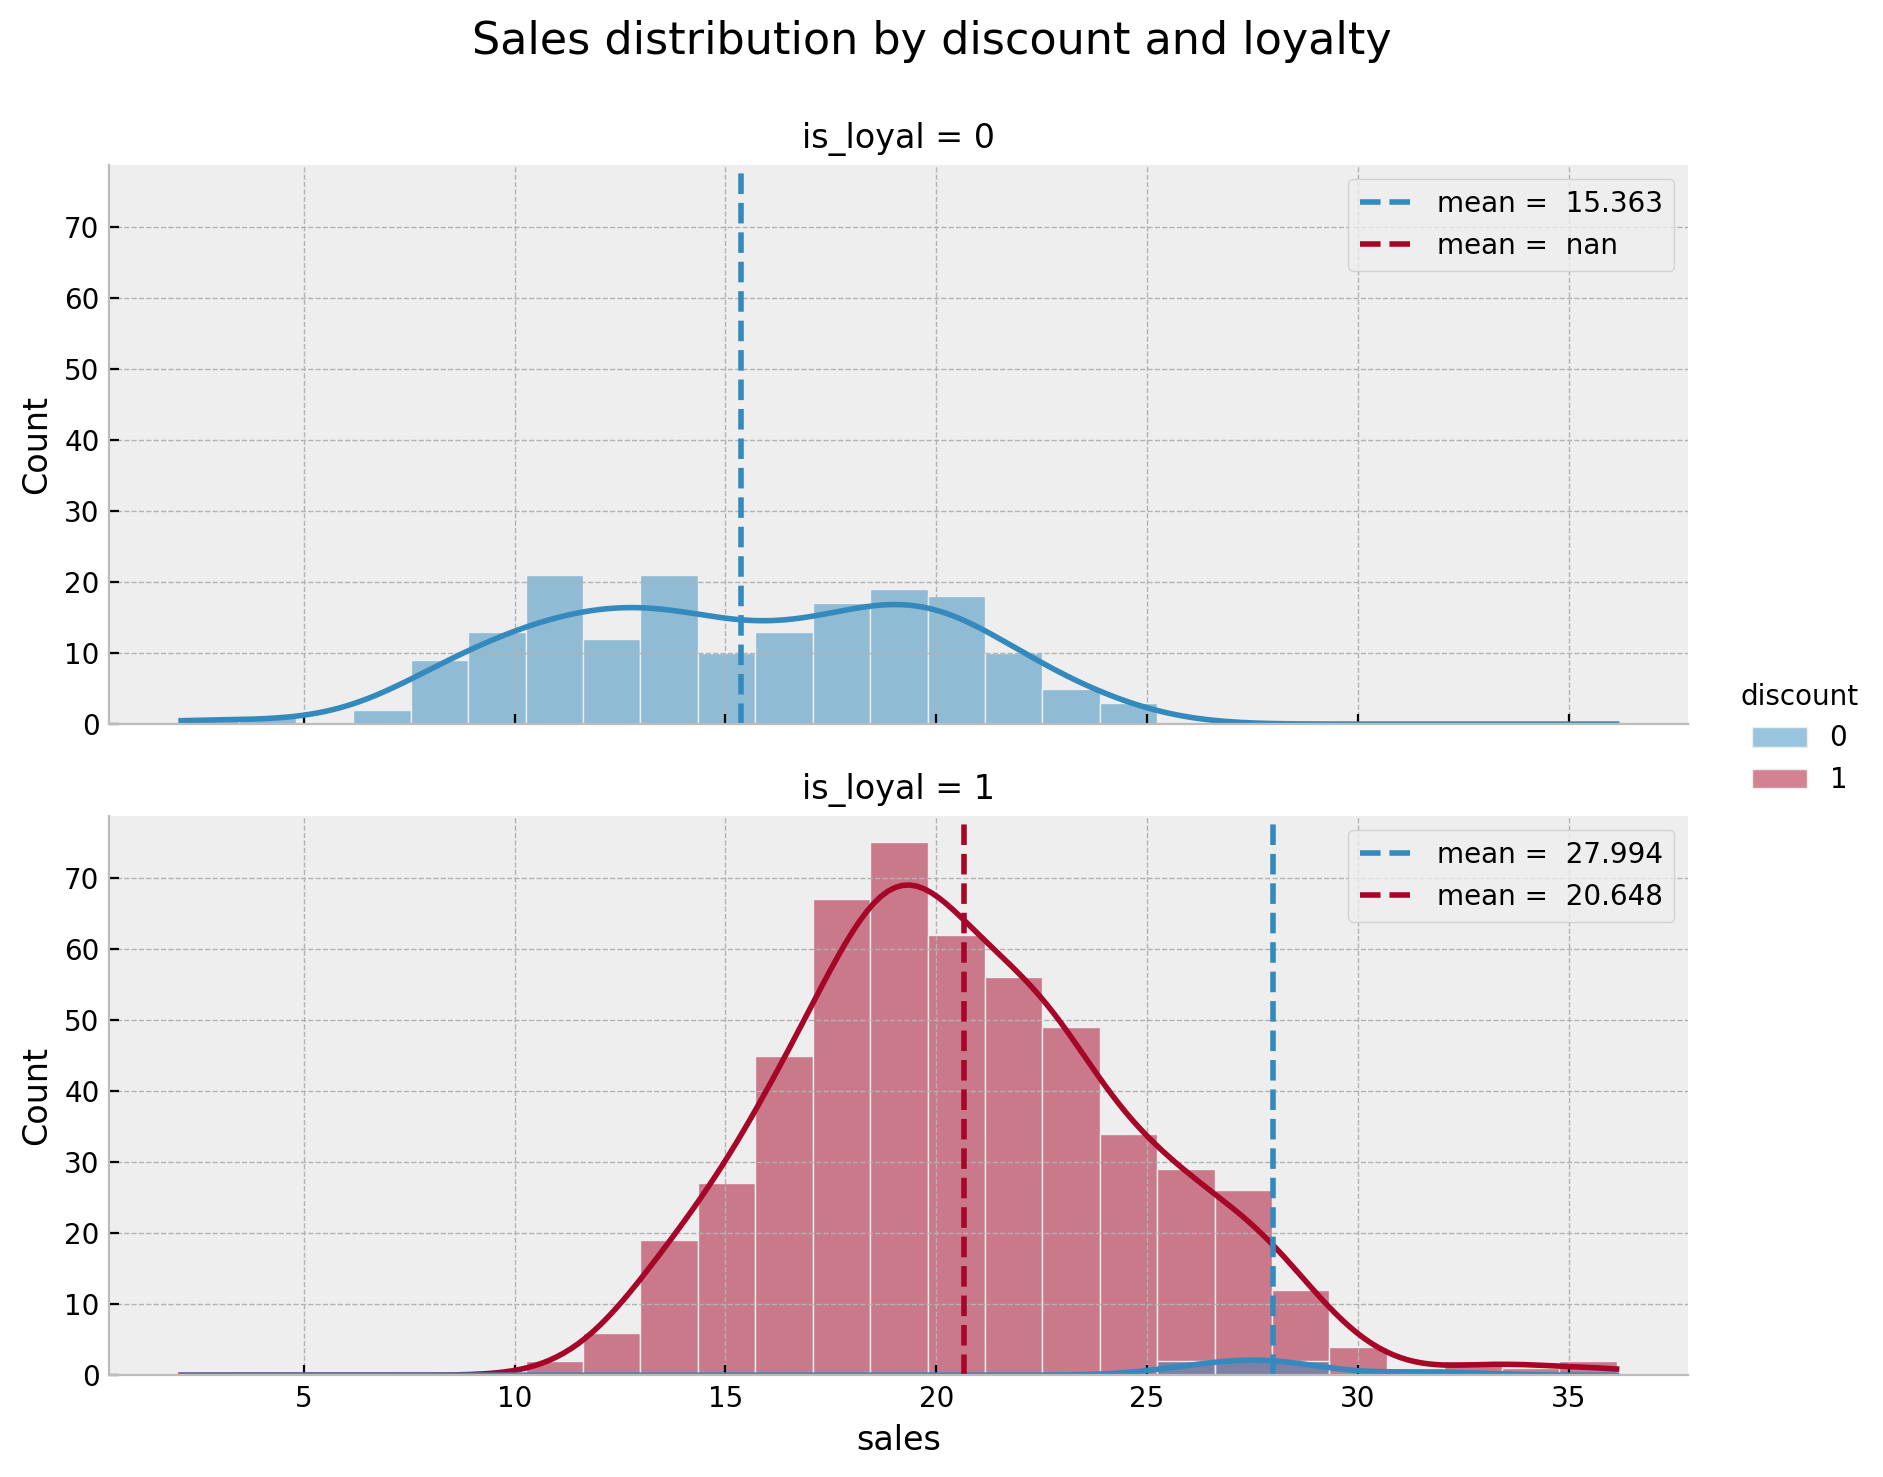

In [18]:
g = sns.displot(
    data=data,
    x="sales",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales"].mean()
        ax.axvline(
            x=df.query(f"discount == {discount}")["sales"].mean(),
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle("Sales distribution by discount and loyalty", y=1.05, fontsize=16)


Ok! This was shocking! They saw that for the loyal customers the sales are much (much!) higher for the discounted group! How could this be? Could it be that the discount strategy is working only for non-loyal customers? According to the plot above, filtering for non loyal customers would yield to a positive uplift:

In [19]:
(
    data.query("discount == 0 & is_loyal == 1")["sales"].mean()
    - data.query("discount == 0 & is_loyal == 0")["sales"].mean()
)


12.631180501353883

In view of the sales distribution and the expectation of the experiments, this looks way to good to be true. The data scientist were very hesitant to recommend pushing discount to non-loyal customers as a result of a $12\$$ uplift on sales. Stakeholders would probably not buy this as the overall average sales per user was around $20\$$.

Data scientist B noticed that the plots above did not factor in the `visits` variable. Hence, they decided to run the analogous plots on the `sales_per_visit` variable:

Text(0.5, 1.05, 'Sales per visit distribution by discount and loyalty')

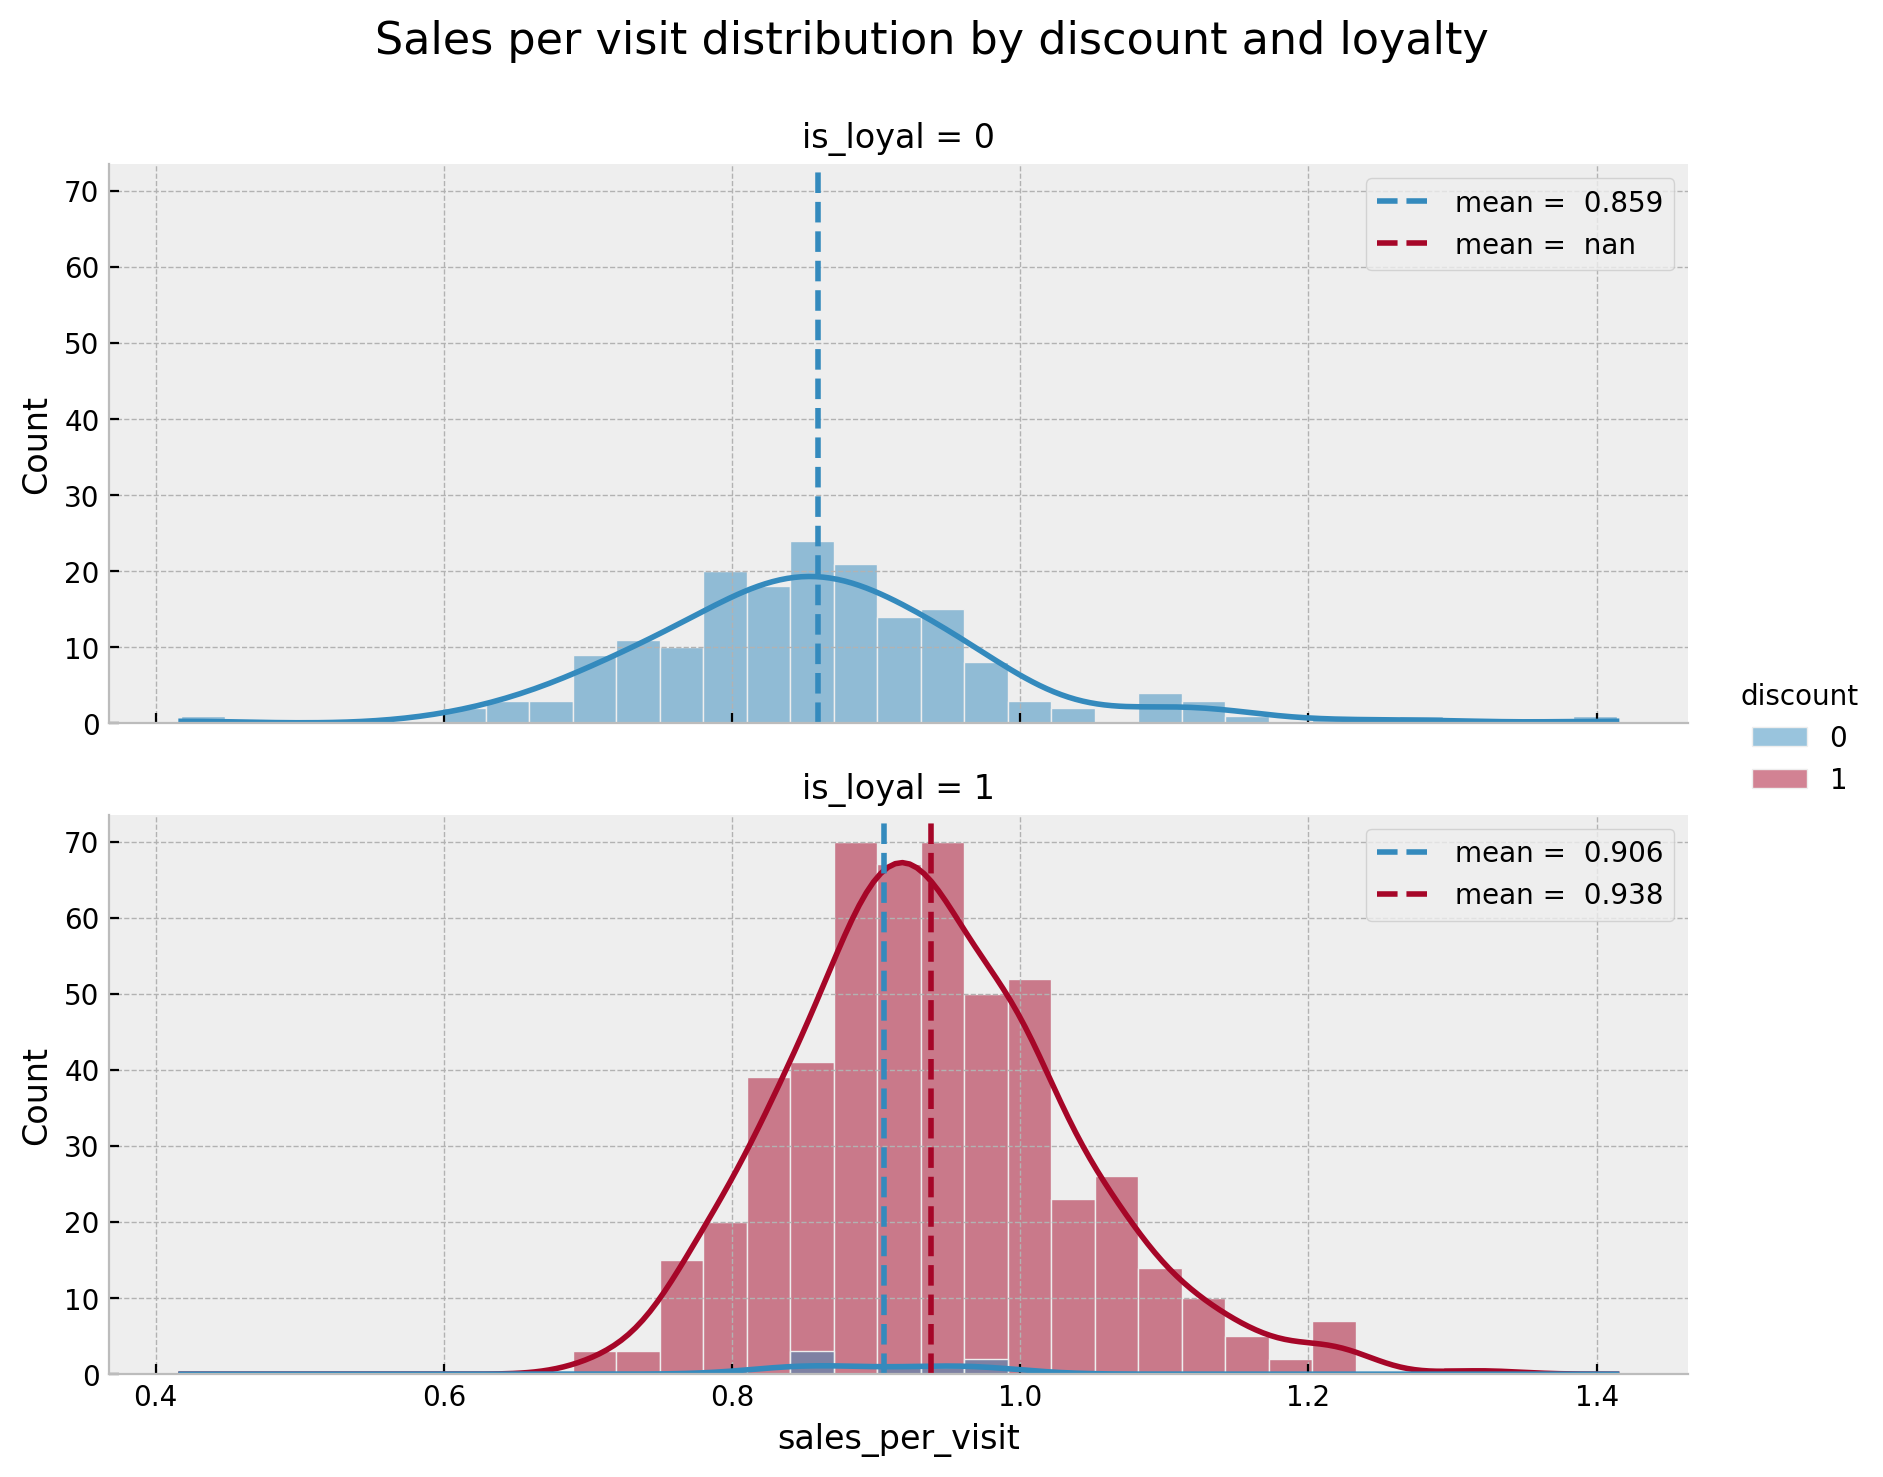

In [20]:
g = sns.displot(
    data=data,
    x="sales_per_visit",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales_per_visit"].mean()
        ax.axvline(
            x=mean,
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle(
    "Sales per visit distribution by discount and loyalty", y=1.05, fontsize=16
)

This plots shows a different story! It seems that loyal customers do react positively to the discount strategy. Also, when just looking to the non-discounted group, they saw the loyal customers had a higher `sales_per_visit` value.

## A Simple Bayesian Linear Regression

At this point the three data scientist were very confused as they had found contradictory results regarding the discount effect on sales. Data scientist D came with a very reasonable suggestion:

> Instead of trying to find the best way to report the results, why don't we try to model the data through a linear model? This way, we can include all the control variables as covariates. We can even use bayesian statistics to present our estimation with uncertainty.


Everyone agreed and they decided to fit a simple Bayesian linear regression model. The data scientist ere familiar with the [bayesian workflow](https://arxiv.org/abs/2011.01808). Here is what they did:

### Specify the Model

In [21]:
# set priors
complete_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "visits": bmb.Prior(
        "Gamma", mu=0.9, sigma=0.3
    ),  # visits has s positive relation with sales
    "discount": bmb.Prior("Normal", mu=0, sigma=5),
    "is_loyal": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("Exponential", lam=1 / 2),
}
# model sales as a function of discount, visits and loyalty
complete_model = bmb.Model(
    formula="sales ~ discount + visits + is_loyal",
    data=data,
    family="gaussian",
    link="identity",
    priors=complete_model_priors,
)

complete_model

       Formula: sales ~ discount + visits + is_loyal
        Family: gaussian
          Link: mu = identity
  Observations: 700
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            discount ~ Normal(mu: 0.0, sigma: 5.0)
            visits ~ Gamma(mu: 0.9, sigma: 0.3)
            is_loyal ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            sales_sigma ~ Exponential(lam: 0.5)

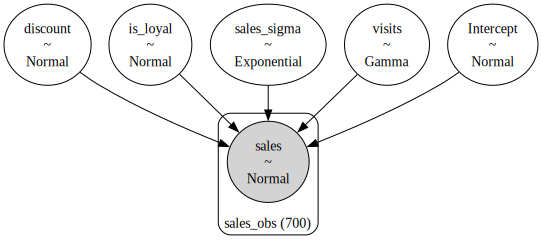

In [22]:
complete_model.build()
complete_model.graph()

### Prior Predictive checks

In [23]:
complete_model_prior_predictive = complete_model.prior_predictive(
    draws=1_000, random_seed=rng
)


Sampling: [Intercept, discount, is_loyal, sales, sales_sigma, visits]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


[Text(0.5, 1.0, 'Complete Model - Prior Predictive')]

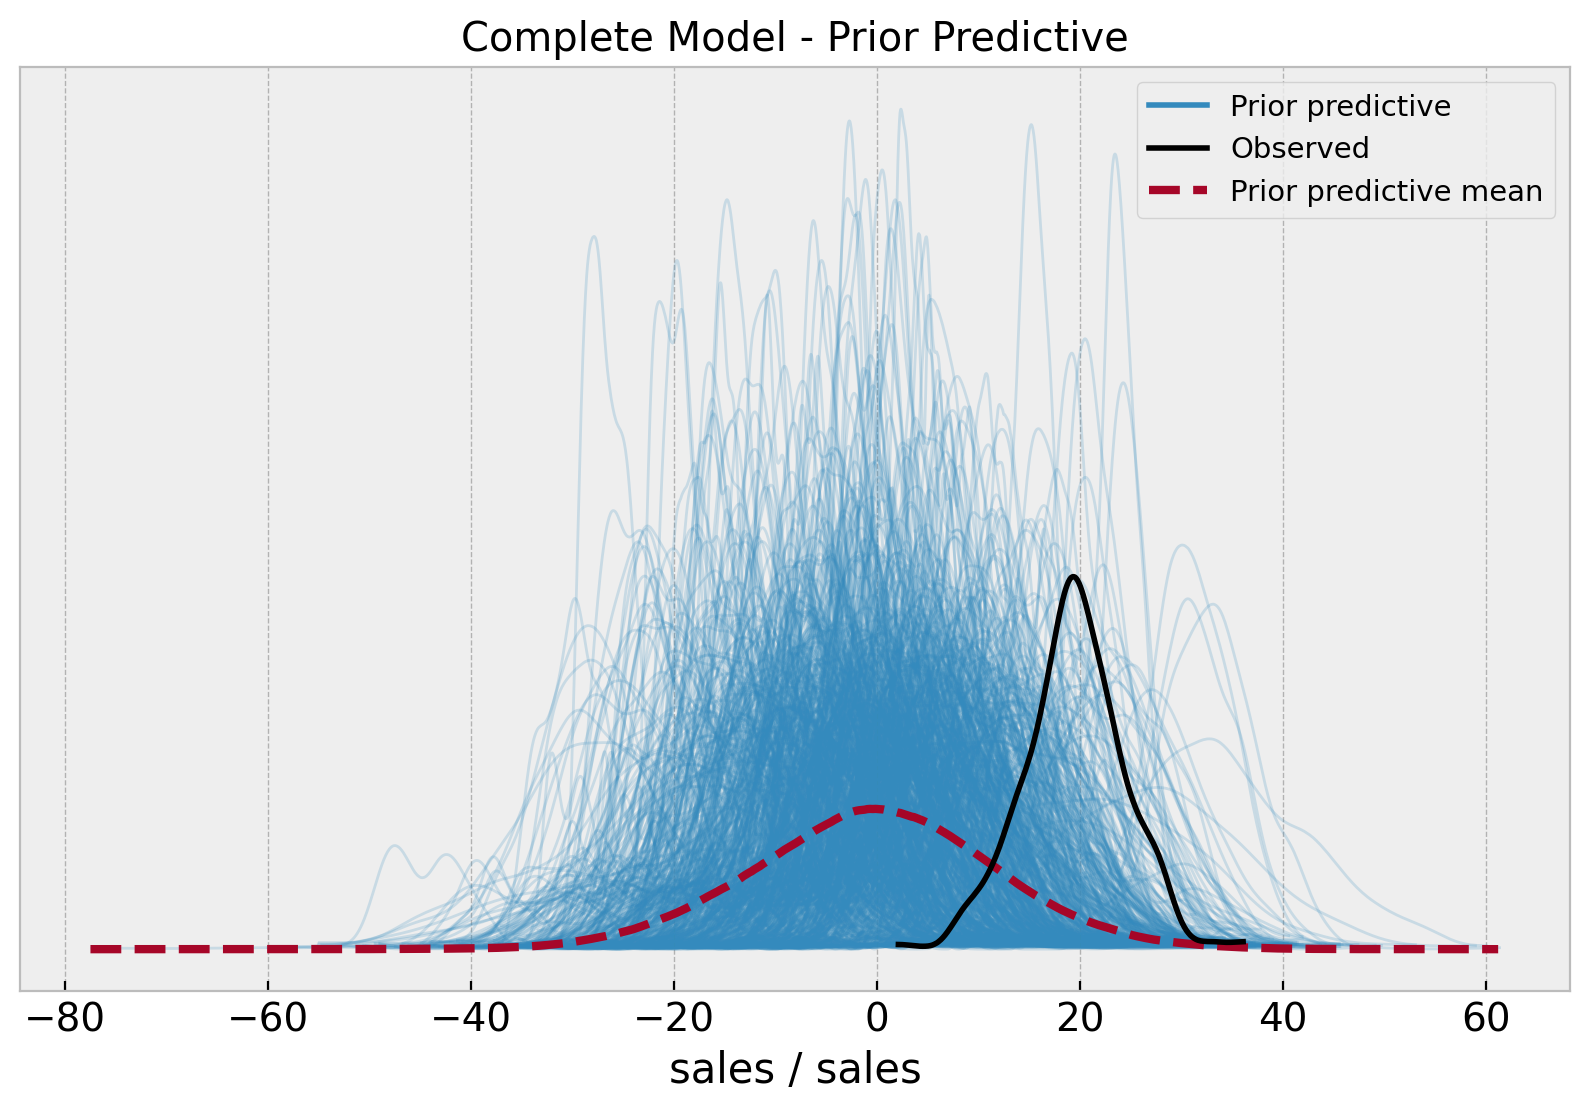

In [24]:
fig, ax = plt.subplots()
az.plot_ppc(data=complete_model_prior_predictive, group="prior", kind="kde", ax=ax)
ax.set(title="Complete Model - Prior Predictive")

The prior specification seems reasonable.

### Model Fit

In [25]:
complete_model_idata = complete_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.798982
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:07.056544
Transforming variables...
Transformation time =  0:00:00.034049


### Posterior Distributions and Diagnostics

We now look into the posterior distribution of the parameters and some model diagnostics.

In [26]:
az.summary(data=complete_model_idata)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    1.113  0.304   0.562    1.700      0.002    0.002   15908.0   
discount    -0.272  0.719  -1.612    1.093      0.007    0.006    9587.0   
is_loyal     2.258  0.740   0.855    3.639      0.007    0.005    9773.0   
sales_sigma  1.891  0.051   1.796    1.986      0.000    0.000   17512.0   
visits       0.792  0.015   0.765    0.821      0.000    0.000   15168.0   

             ess_tail  r_hat  
Intercept     14157.0    1.0  
discount       9945.0    1.0  
is_loyal      10658.0    1.0  
sales_sigma   12699.0    1.0  
visits        11925.0    1.0

Text(0.5, 0.98, 'Complete Model - Trace')

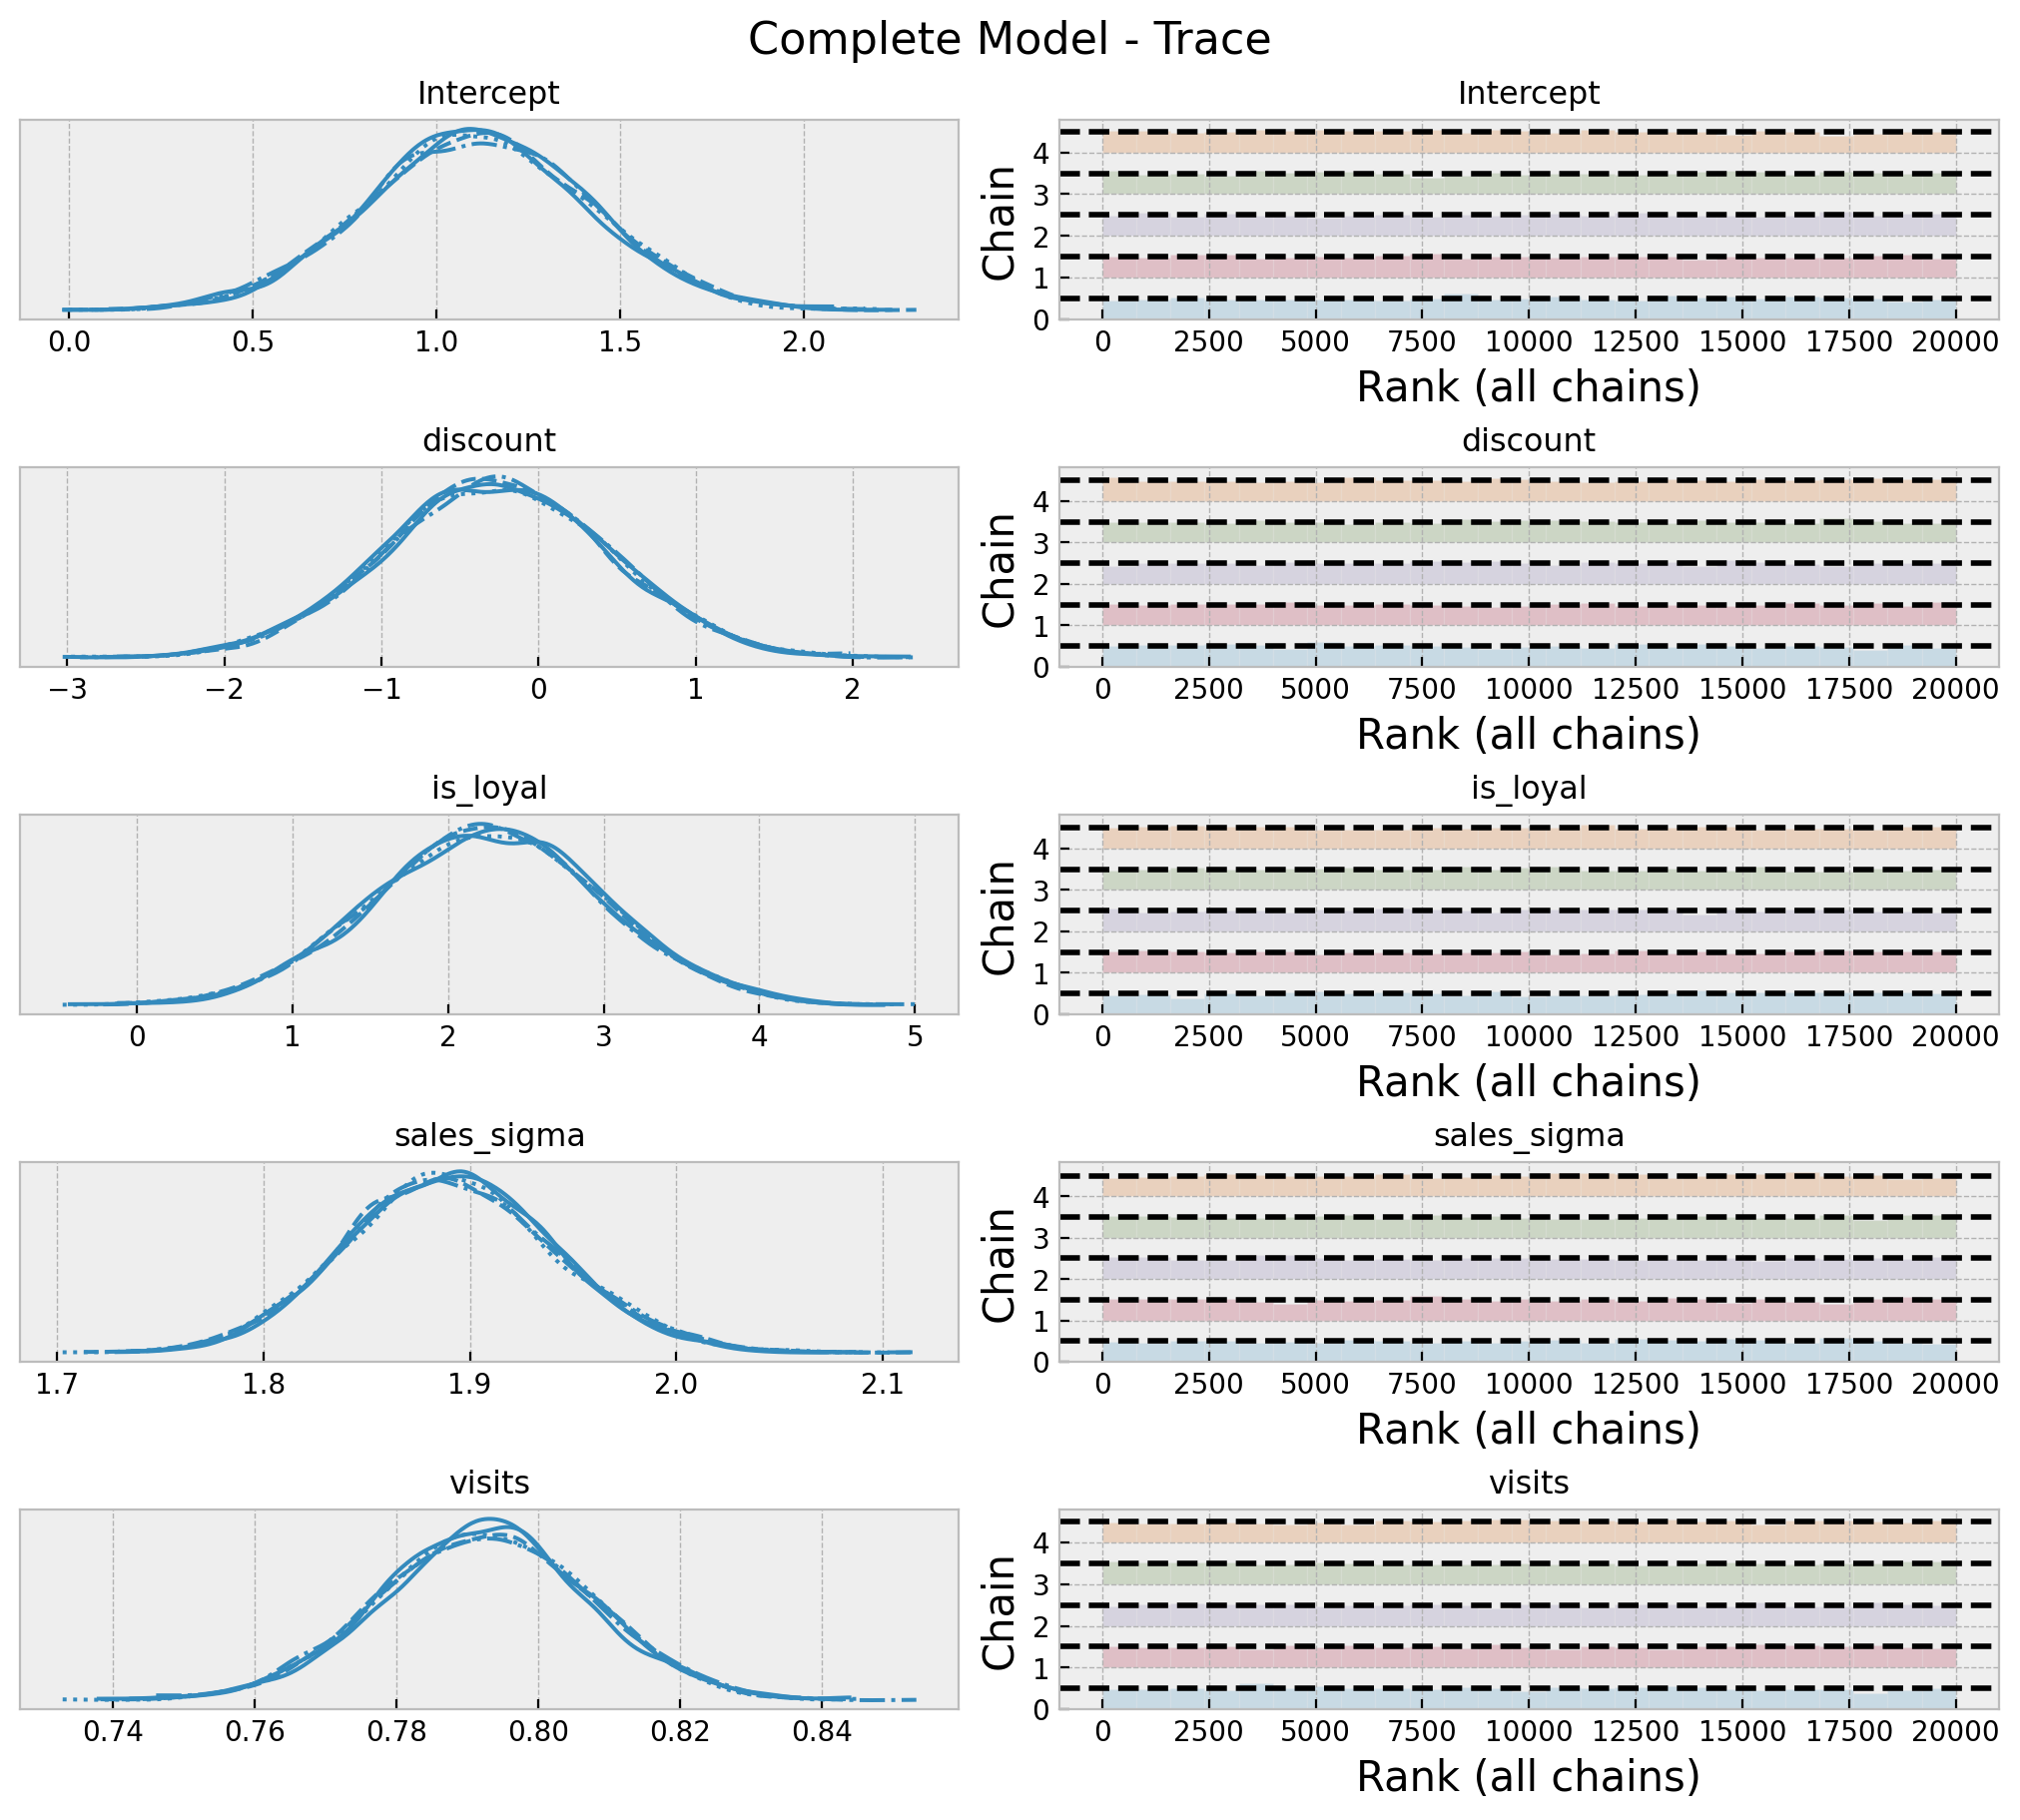

In [27]:
axes = az.plot_trace(
    data=complete_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Complete Model - Trace", fontsize=16)

It seems the discount distribution contains zero and the posterior predictive mean effect is slightly negative. We can zoom in into the posterior distribution of the discount effect:

<AxesSubplot:title={'center':'discount'}>

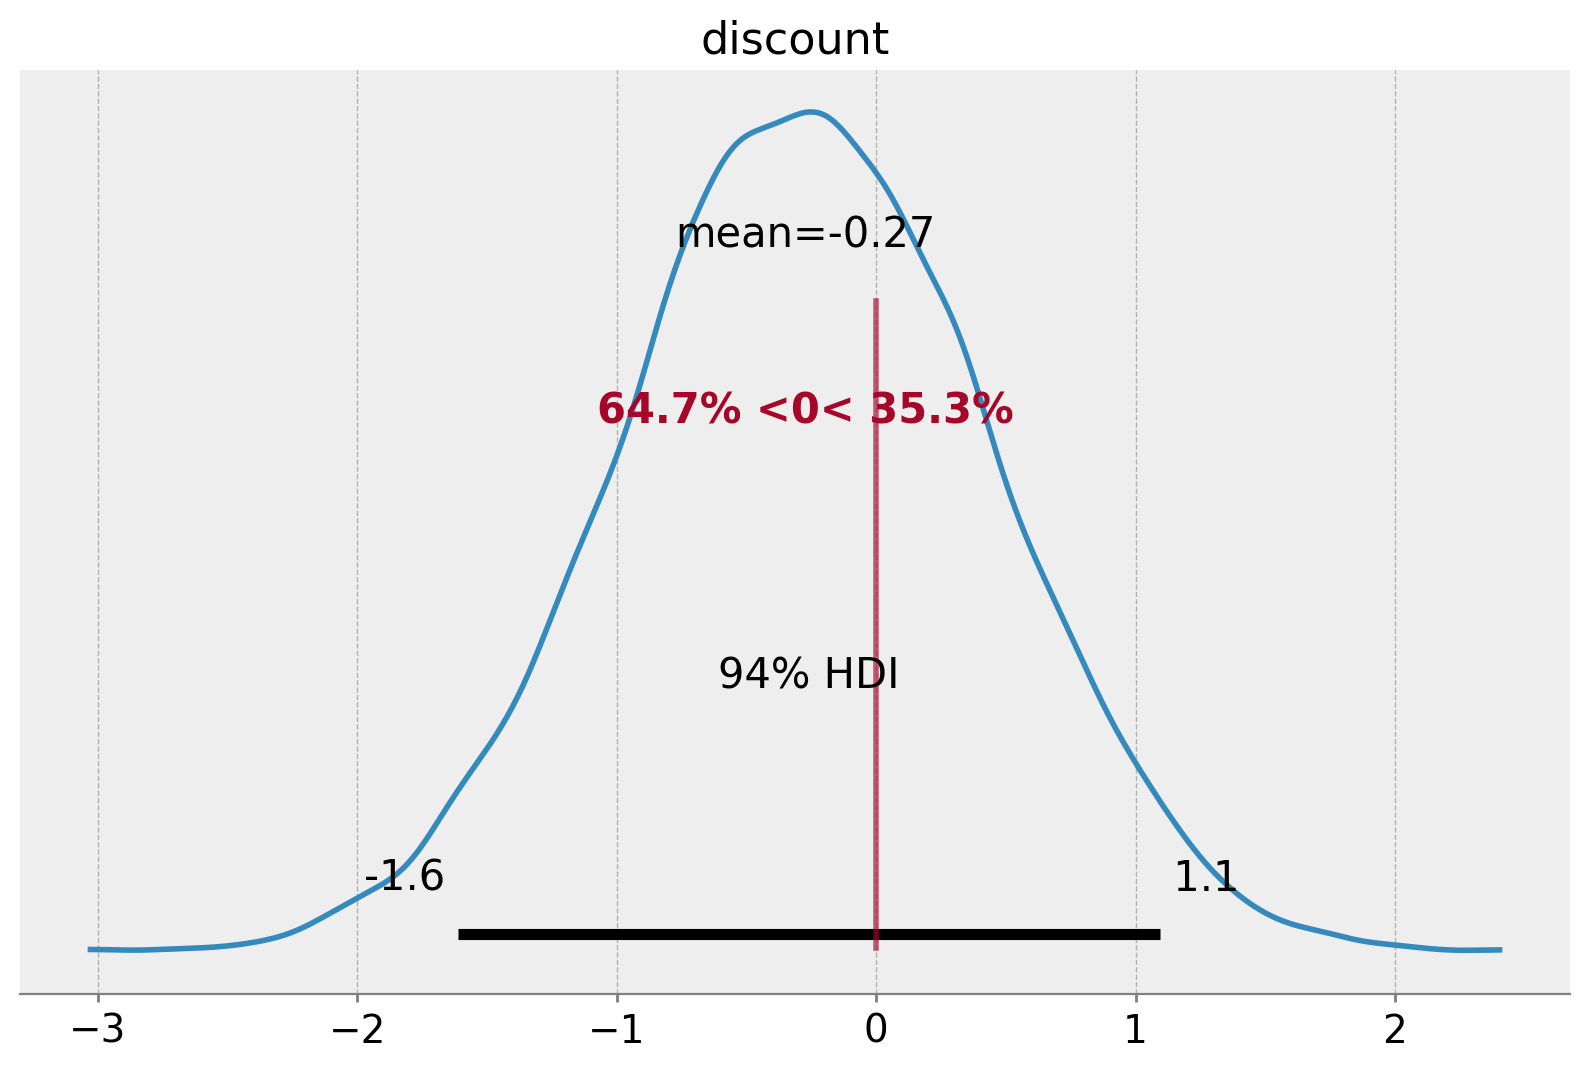

In [28]:
fig, ax = plt.subplots()
az.plot_posterior(data=complete_model_idata, var_names=["discount"], ref_val=0, ax=ax)


The data scientists were puzzled about the result and unsure how to communicate this slight negative effect to the marketing team.

### Posterior Predictive Checks

In [29]:
complete_model.predict(idata=complete_model_idata, kind="pps", inplace=True)

[Text(0.5, 1.0, 'Complete Model - Posterior Predictive')]

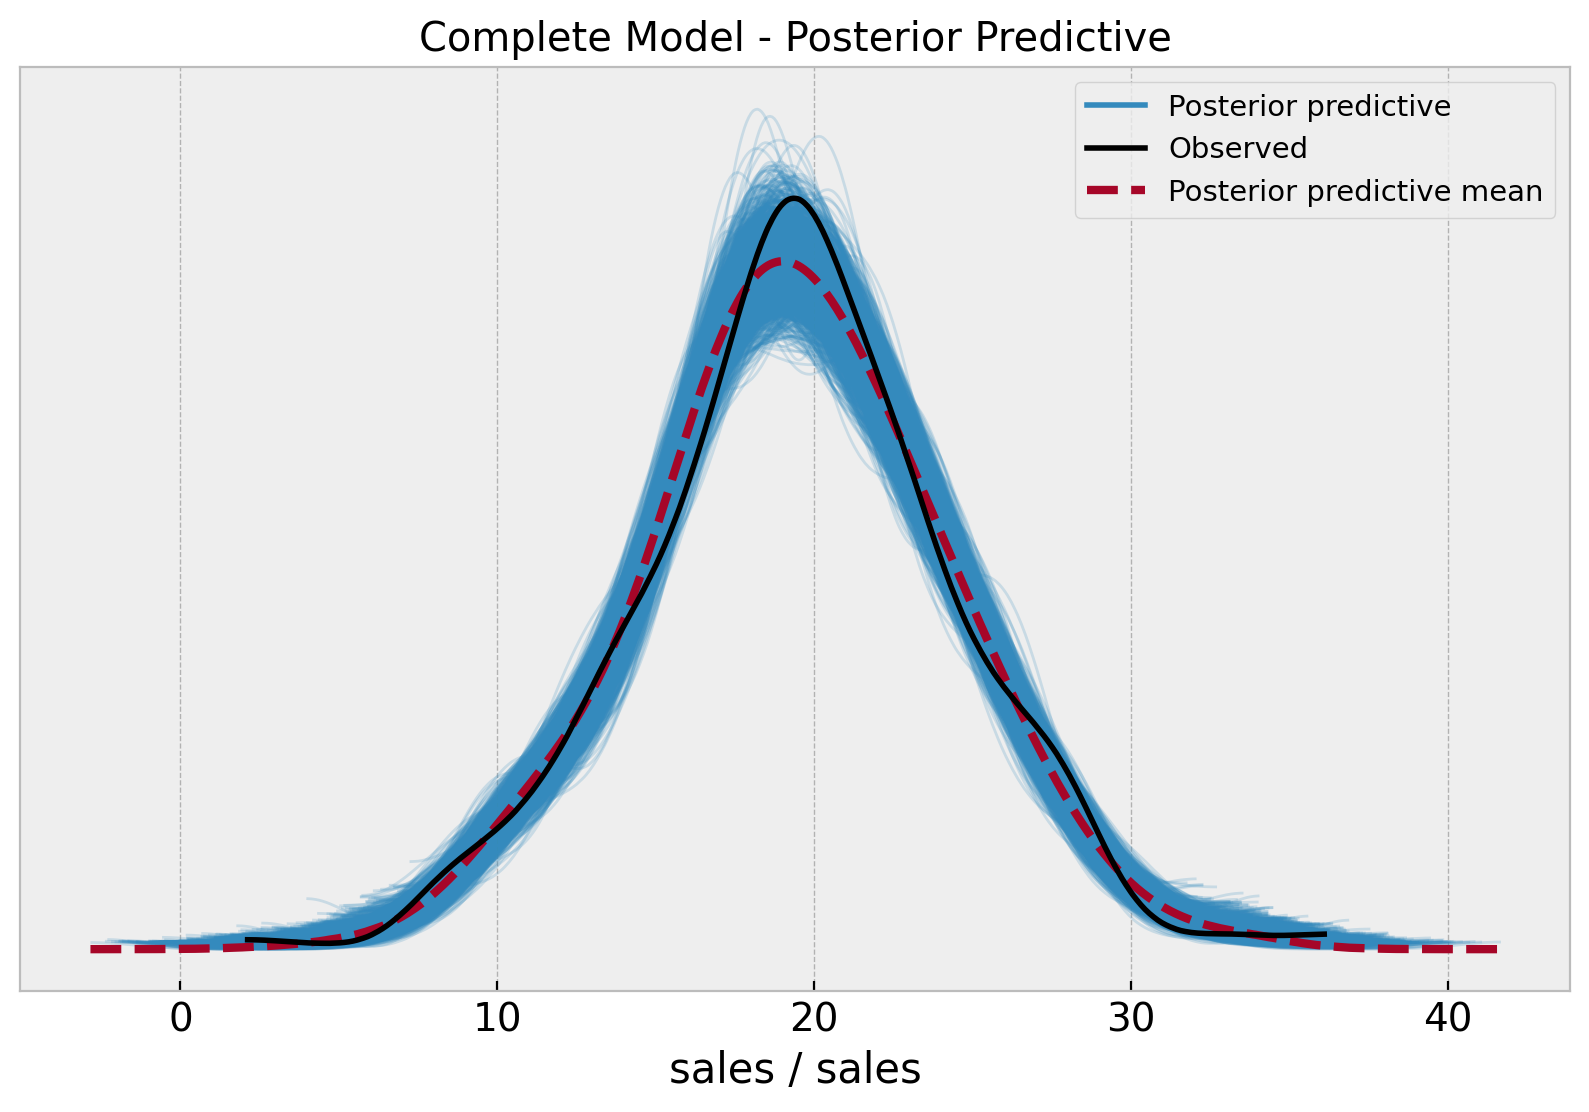

In [30]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=complete_model_idata,
    group="posterior",
    kind="kde",
    num_pp_samples=2_000,
    random_seed=seed,
    ax=ax,
)
ax.set(title="Complete Model - Posterior Predictive")


The model posterior predictive looks good. The model seems to be able to capture the data.

## A Machine Learning Approach

Fortunately, data scientist E came with an alternative approach:

> You folks are trying to make sense of complex relationships by looking at simple plots and summary statistics. Why don't you try to fit a machine learning model to the data and see what happens? This way we can simply let the data and the model figure out the relationships between the variables. We can do a post-processing on the predictions using, for example, [partial dependency plots](https://scikit-learn.org/stable/modules/partial_dependence.html):  which *show the marginal effect one or two features have on the predicted outcome of a machine learning model*. (see [here](https://christophm.github.io/interpretable-ml-book/pdp.html))

Everyone was thrilled! They would impress everyone with a machine learning model 🤓! 

The strategy was now simple: train a non-linear machine learning model (as they were expecting complex relationships) and use partial dependency plots to estimate the discount effect. As good data scientists, they would also use cross-validation to avoid over-fitting, despite the fact they were not interested in out-of-sample predictions.

In [31]:
# specify variables.
# we use all the variables in the dataset to reduce the variance of
# the estimates (what could go wrong right ¯\_(ツ)_/¯ ?).
numeric_features = ["visits"]
categorical_features = ["discount", "is_loyal"]
features = numeric_features + categorical_features

# define the model data.
X = data.assign(
    discount=lambda x: pd.Categorical(values=x["discount"], categories=[0, 1]),
    is_loyal=lambda x: pd.Categorical(values=x["is_loyal"], categories=[0, 1]),
).filter(items=features)

y = data["sales"].to_numpy()

# specify model and hyperparameters.
ml_model = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=seed),
    param_distributions=dict(
        learning_rate=uniform(loc=0.01, scale=0.1),
        n_estimators=randint(low=100, high=1_000),
        max_depth=randint(low=3, high=9),
    ),
    cv=8,
    n_iter=12,
    random_state=seed,
)

# fit the model.
ml_model.fit(X=X, y=y)


RandomizedSearchCV(cv=8, estimator=GradientBoostingRegressor(random_state=975),
                   n_iter=12,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1443aa0b0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148e0cf10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x10cc667d0>},
                   random_state=975)

The model was trained 🤖 successfully! Of course, it was important to at least check the model fit.

[Text(0.5, 1.0, 'ML Model - Actual vs Predicted Sales'),
 Text(0.5, 0, 'Actual'),
 Text(0, 0.5, 'Predicted')]

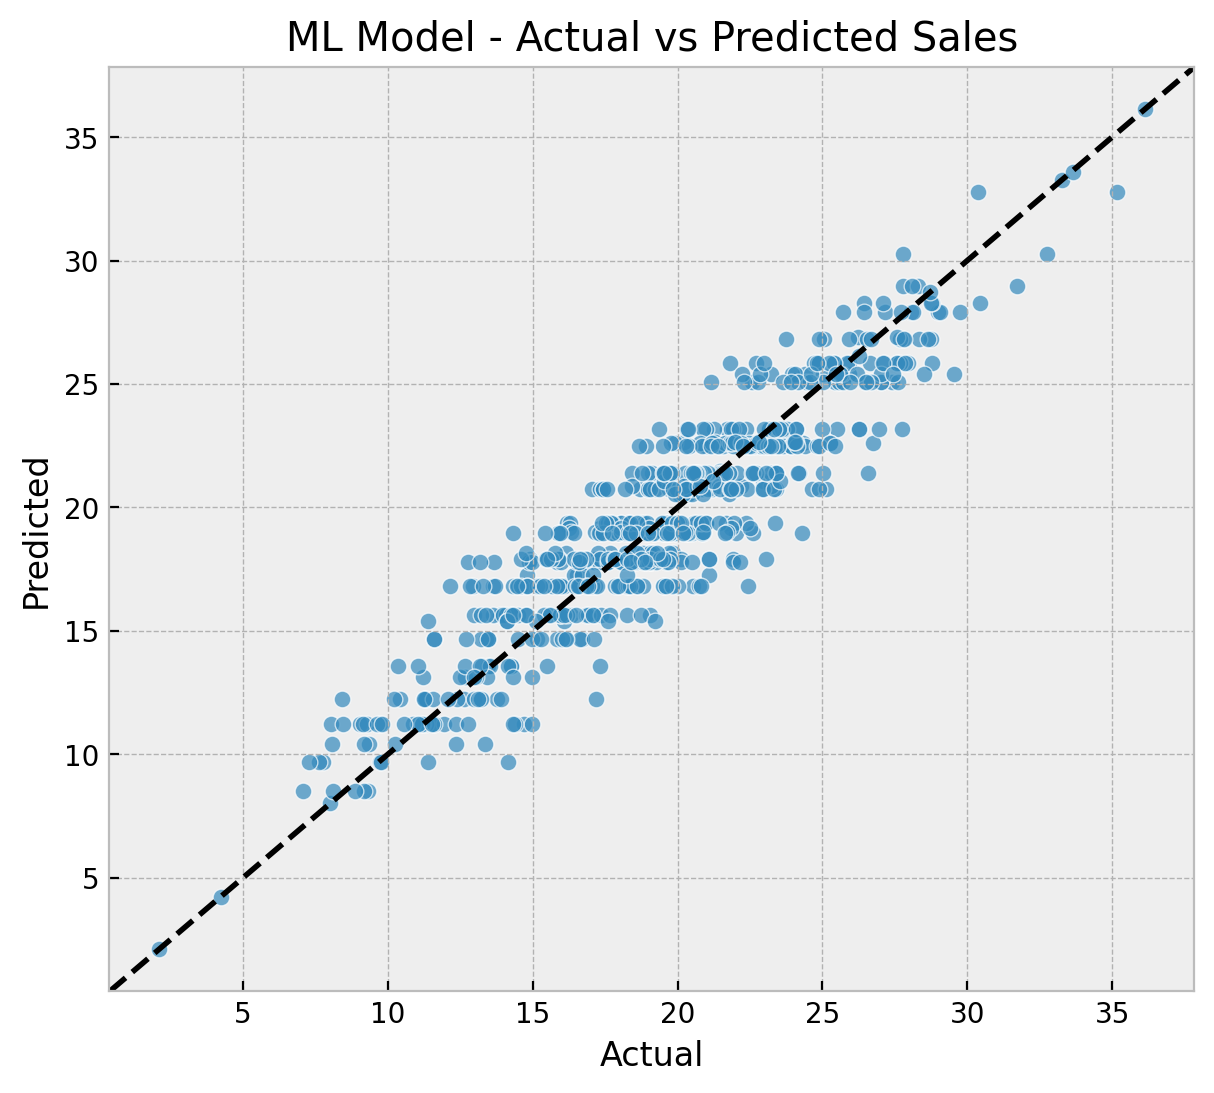

In [32]:
# generate in-sample predictions
y_pred = ml_model.predict(X=X)

# plot true vs predicted values
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(x=y, y=y_pred, color="C0", alpha=0.7, ax=ax)
ax.axline(xy1=(10, 10), slope=1, color="black", linestyle="--")
ax.set(
    title="ML Model - Actual vs Predicted Sales", xlabel="Actual", ylabel="Predicted"
)


The predictions look ok. For example, the variance explained looks similar to the one from the linear model.

Let's move to the question of interest: the discount effect. The data scientist computed the partial dependency plot for the `discount` and `is_loyal` variables. They presented absolute and relative effects.

Text(0.5, 1.05, 'ML Model - Partial Dependence Plots')

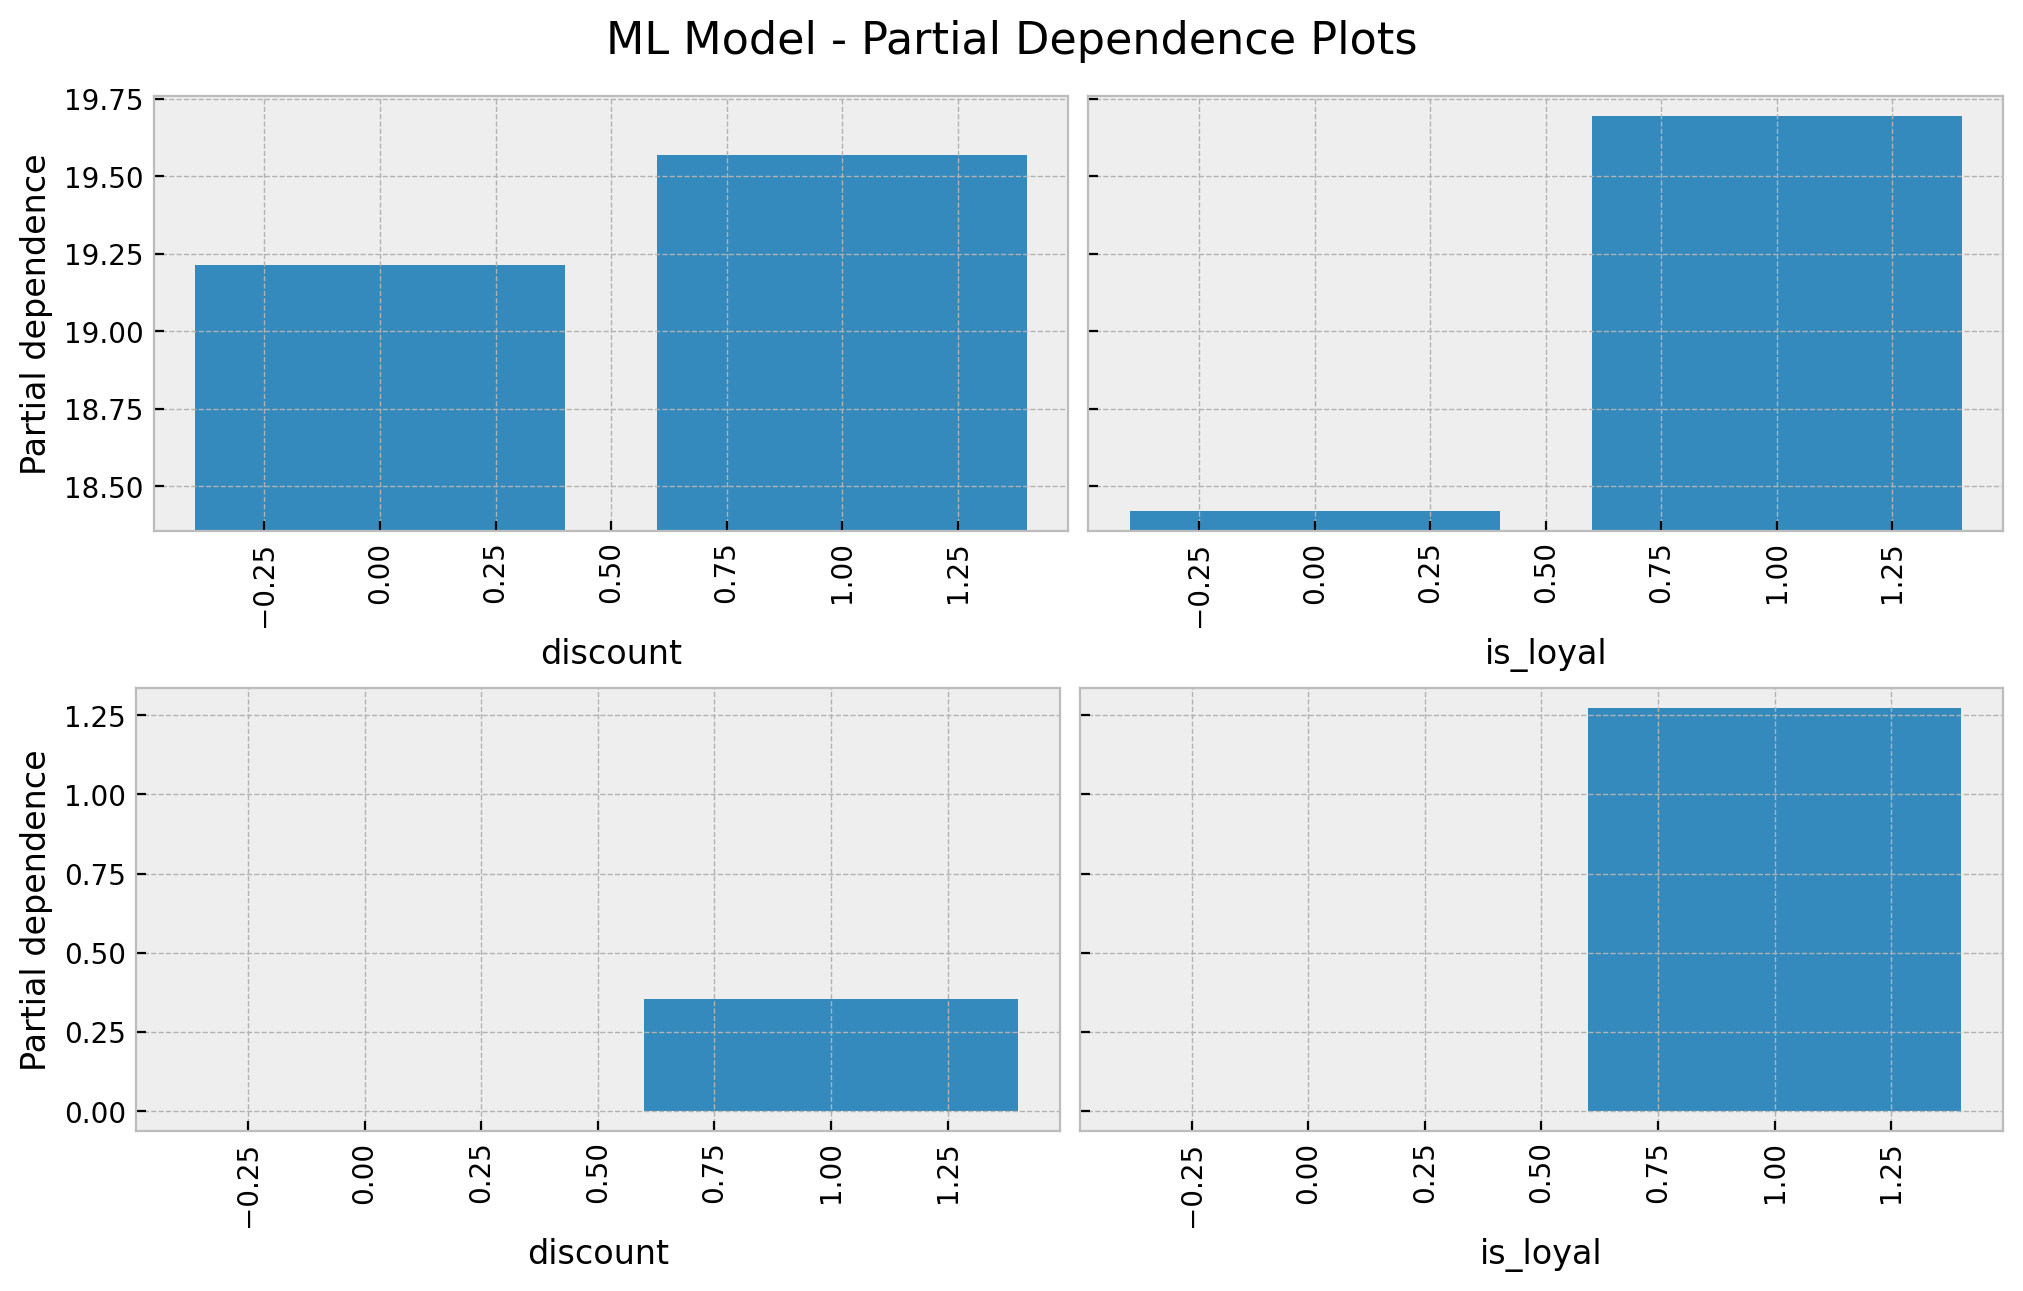

In [33]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained"
)

for b in [False, True]:
    PartialDependenceDisplay.from_estimator(
        estimator=ml_model,
        X=X,
        features=categorical_features,
        categorical_features=categorical_features,
        centered=b,
        random_state=seed,
        ax=ax[int(b)],
    )
fig.suptitle("ML Model - Partial Dependence Plots", y=1.05, fontsize=16)

According to the machine learning model, the discount **does have a positive effect on sales**. The relative partial dependency plot hint that the additional sales driven by the discount are are around $0.35\$$. This is less than the limit $1\$$ set by the marketing team to obtain a positive ROI. 

## Conclusions and Recommendations

Based on the results from the linear model and the machine learning model, the data scientist decided to recommend the following:
> **Stop the discount strategy as on average it provides less than $1\$$ additional sales, which implies a negative ROI**.

---

# Part 2: The Mistake and Learnings

What if I told you that the true average discount effect is $2\$$ and therefore the best strategy is to keep the discount strategy? How do I know it? Well, I generated the data (see [here](https://github.com/juanitorduz/website_projects/blob/master/Python/sales_dag.py)). Do not take me wrong, I generated the data exactly as it was designed to be from the requirements listed at the very beginning. So what went wrong? What did the data scientist miss? If you are thinking about using more sophisticated models, you are wrong. The problem is not the model, but the data understanding.

Let me bring again the description of the campaign:

- Select a sample of existing customers from the same cohort.
- Set a test window of 1 month.
- Look into the historical data of web visits from the last month. The hypothesis is that web visits are a good proxy for the customer's interest in the product.
- For customers with a high number of web visits, send them a discount. There will be a hold out group which will not receive the discount within the potential valuable customers based on the number of web visits. For customers with a low number of web visits, do not send them a discount (the marketing team wants to report a positive ROI, so they do not want to waste money on customers which are not valuable). Still, they want to use them to measure the effect of the discount.
- We also want to use the results of the test to cluster tag *loyal* customers. These are customers which got a discount (since they showed potential interest in the product) and customers with exceptional sales numbers even if they did not get a discount. The idea is to use this information to target them in the future if the discount strategy is positive.

It is always recommended to truly understand the implications and assumptions of the data generating process. A data structure which visually an analytically can support this understanding is a DAG (directed acyclic graph). Here is the DAG for the data generating process of the campaign:

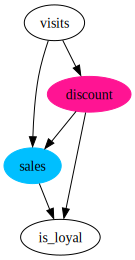

In [34]:
g = gr.Digraph()
g.node(name="sales", label="sales", color="deepskyblue", style="filled")
g.node(name="discount", label="discount", color="deeppink", style="filled")
g.edge(tail_name="discount", head_name="sales")
g.edge(tail_name="visits", head_name="discount")
g.edge(tail_name="visits", head_name="sales")
g.edge(tail_name="discount", head_name="is_loyal")
g.edge(tail_name="sales", head_name="is_loyal")
g

The following are the main structural remarks from the DAG:
- Both the discounts (treatment) and sales (target) are affected by the number of web visits (proxy for customer's interest in the product). This means that the number of web visits is a confounder variable.
- However, the loyalty of the customer is defined by both the discounts and the sales. This means that the loyalty is a collider variable.

If this sounds strange to you, is ok, the causal inference jargon is not easy to understand at the beginning (please see the **References** section below). What is important is that the `visits` variable is a confounding variable which is important to control for because it is creating a bias as we are actively giving more discounts to more engaged users. However, on the other hand, the `is_loyal` variable is a collider variable which is creating an spurious relationship between the `discount` and `sales` variables. **This was the data scientists mistake!** Note that we do not care if we estimate effect with a linear model or a gradient boosting tree ensemble, the problem is the features we select for the model!

## Causal Bayesian Regression Model

In view of the remark above regarding *bad control* variables, let's fit the same Bayesian linear regression model but now controlling for the `is_loyal` variable.

### Specify the Model

In [35]:
causal_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "visits": bmb.Prior(
        "Gamma", mu=0.9, sigma=0.3
    ),  # visits has s positive relation with sales
    "discount": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("Exponential", lam=1 / 2),
}

causal_model = bmb.Model(
    formula="sales ~ discount + visits",
    data=data,
    family="gaussian",
    link="identity",
    priors=causal_model_priors,
)

causal_model


       Formula: sales ~ discount + visits
        Family: gaussian
          Link: mu = identity
  Observations: 700
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            discount ~ Normal(mu: 0.0, sigma: 5.0)
            visits ~ Gamma(mu: 0.9, sigma: 0.3)
        
        Auxiliary parameters
            sales_sigma ~ Exponential(lam: 0.5)

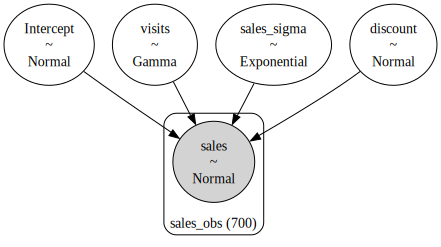

In [36]:
causal_model.build()
causal_model.graph()

### Prior Predictive Checks

For sanity checks, we look into the prior predictive distribution.

In [37]:
causal_model_prior_predictive = causal_model.prior_predictive(
    draws=1_000, random_seed=rng
)


Sampling: [Intercept, discount, sales, sales_sigma, visits]


[Text(0.5, 1.0, 'Causal Model - Prior Predictive')]

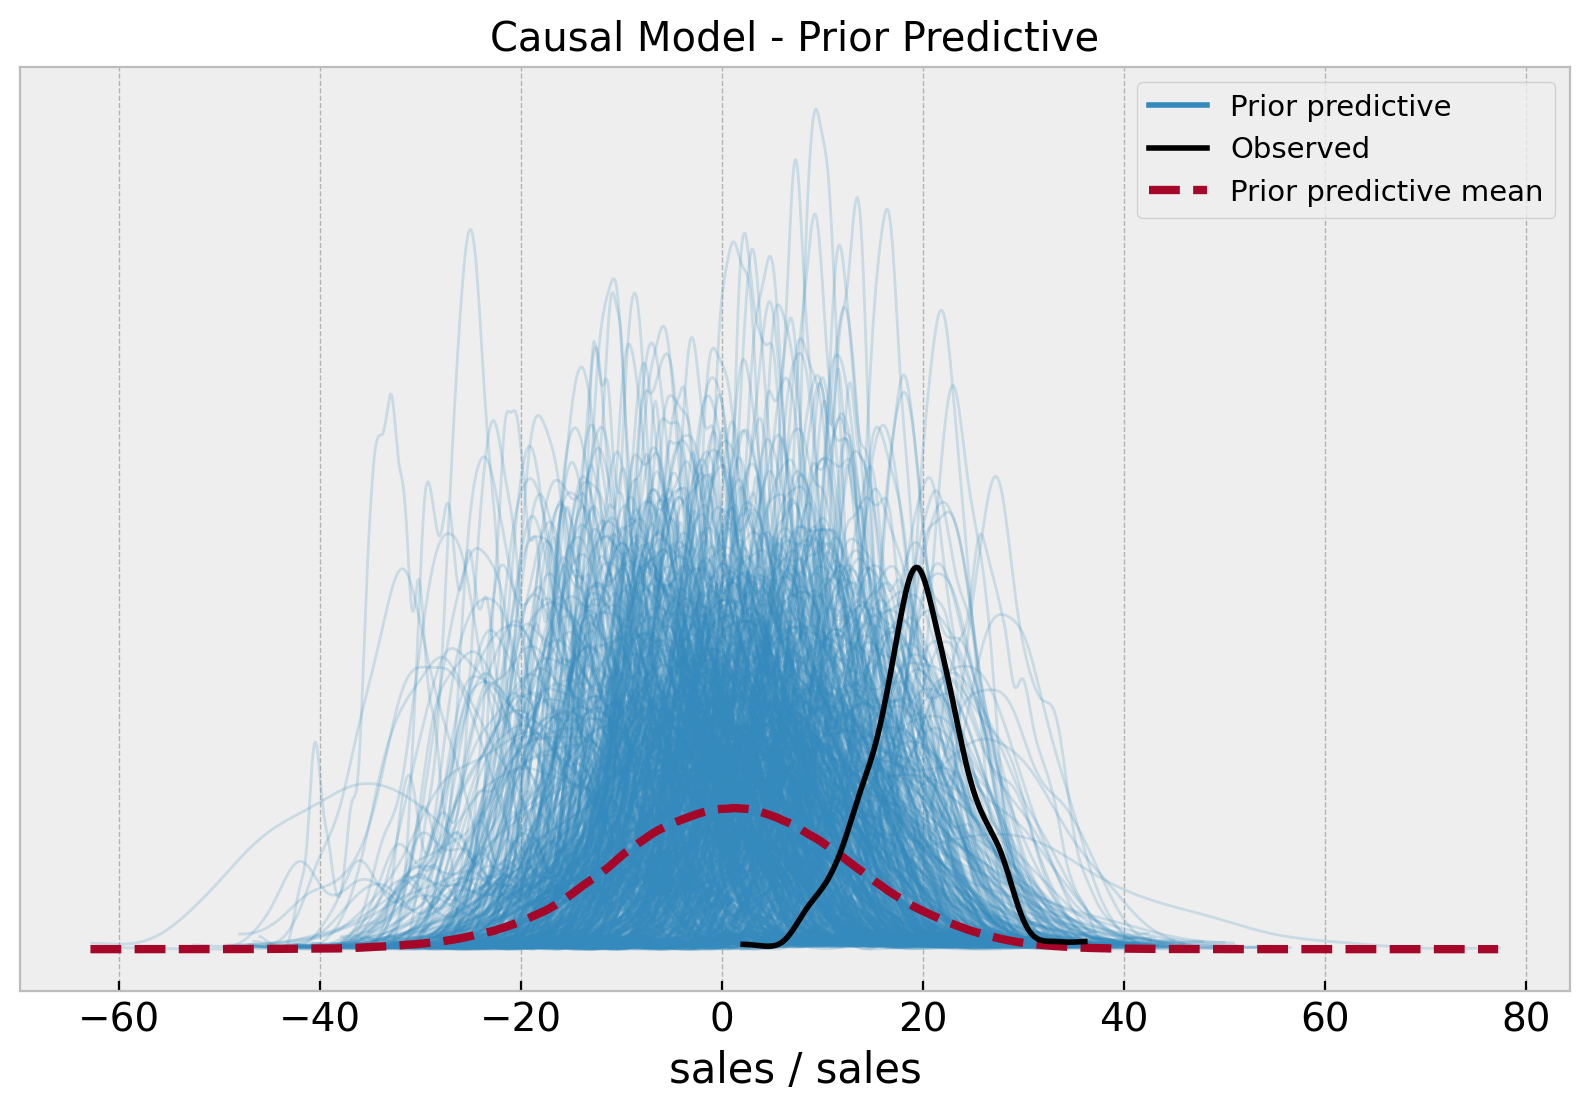

In [38]:
fig, ax = plt.subplots()
az.plot_ppc(data=causal_model_prior_predictive, group="prior", kind="kde", ax=ax)
ax.set(title="Causal Model - Prior Predictive")

It looks ok!

### Model Fit

We now fit the model.

In [39]:
causal_model_idata = causal_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.229310
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:05.491849
Transforming variables...
Transformation time =  0:00:00.018093


### Posterior Distributions and Diagnostics

In [40]:
az.summary(data=causal_model_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    0.986  0.305   0.389    1.530      0.002    0.001   24630.0   
discount     1.852  0.171   1.541    2.184      0.001    0.001   18262.0   
sales_sigma  1.904  0.051   1.807    1.999      0.000    0.000   19970.0   
visits       0.804  0.015   0.778    0.833      0.000    0.000   20240.0   

             ess_tail  r_hat  
Intercept     15742.0    1.0  
discount      15417.0    1.0  
sales_sigma   14733.0    1.0  
visits        15558.0    1.0

Text(0.5, 0.98, 'Causal Model - Trace')

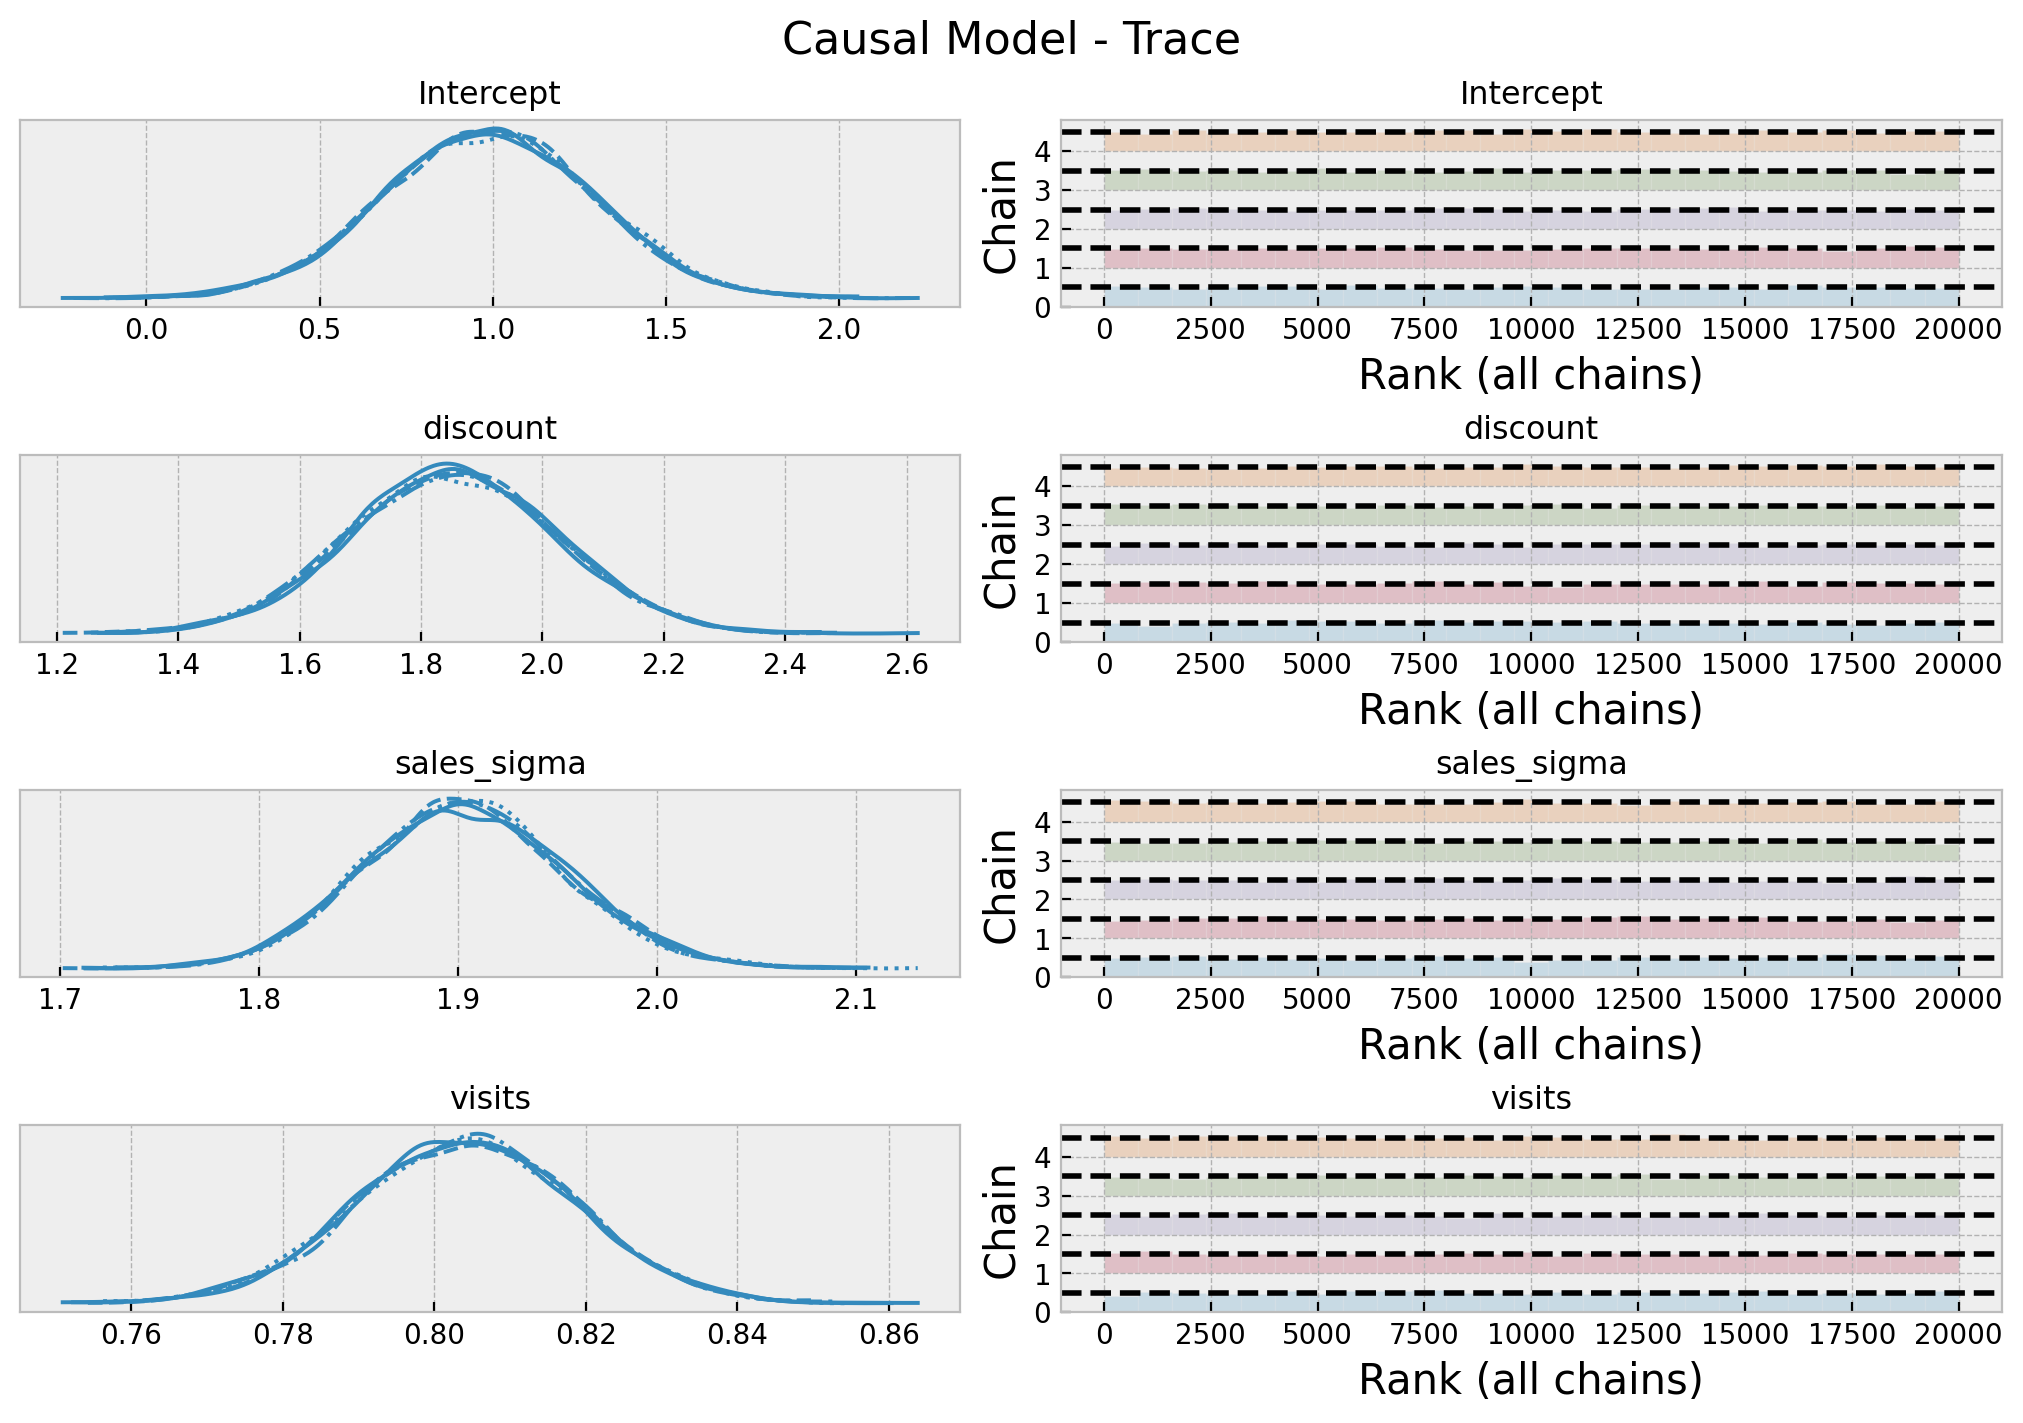

In [41]:
axes = az.plot_trace(
    data=causal_model_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Causal Model - Trace", fontsize=16)

<AxesSubplot:title={'center':'discount'}>

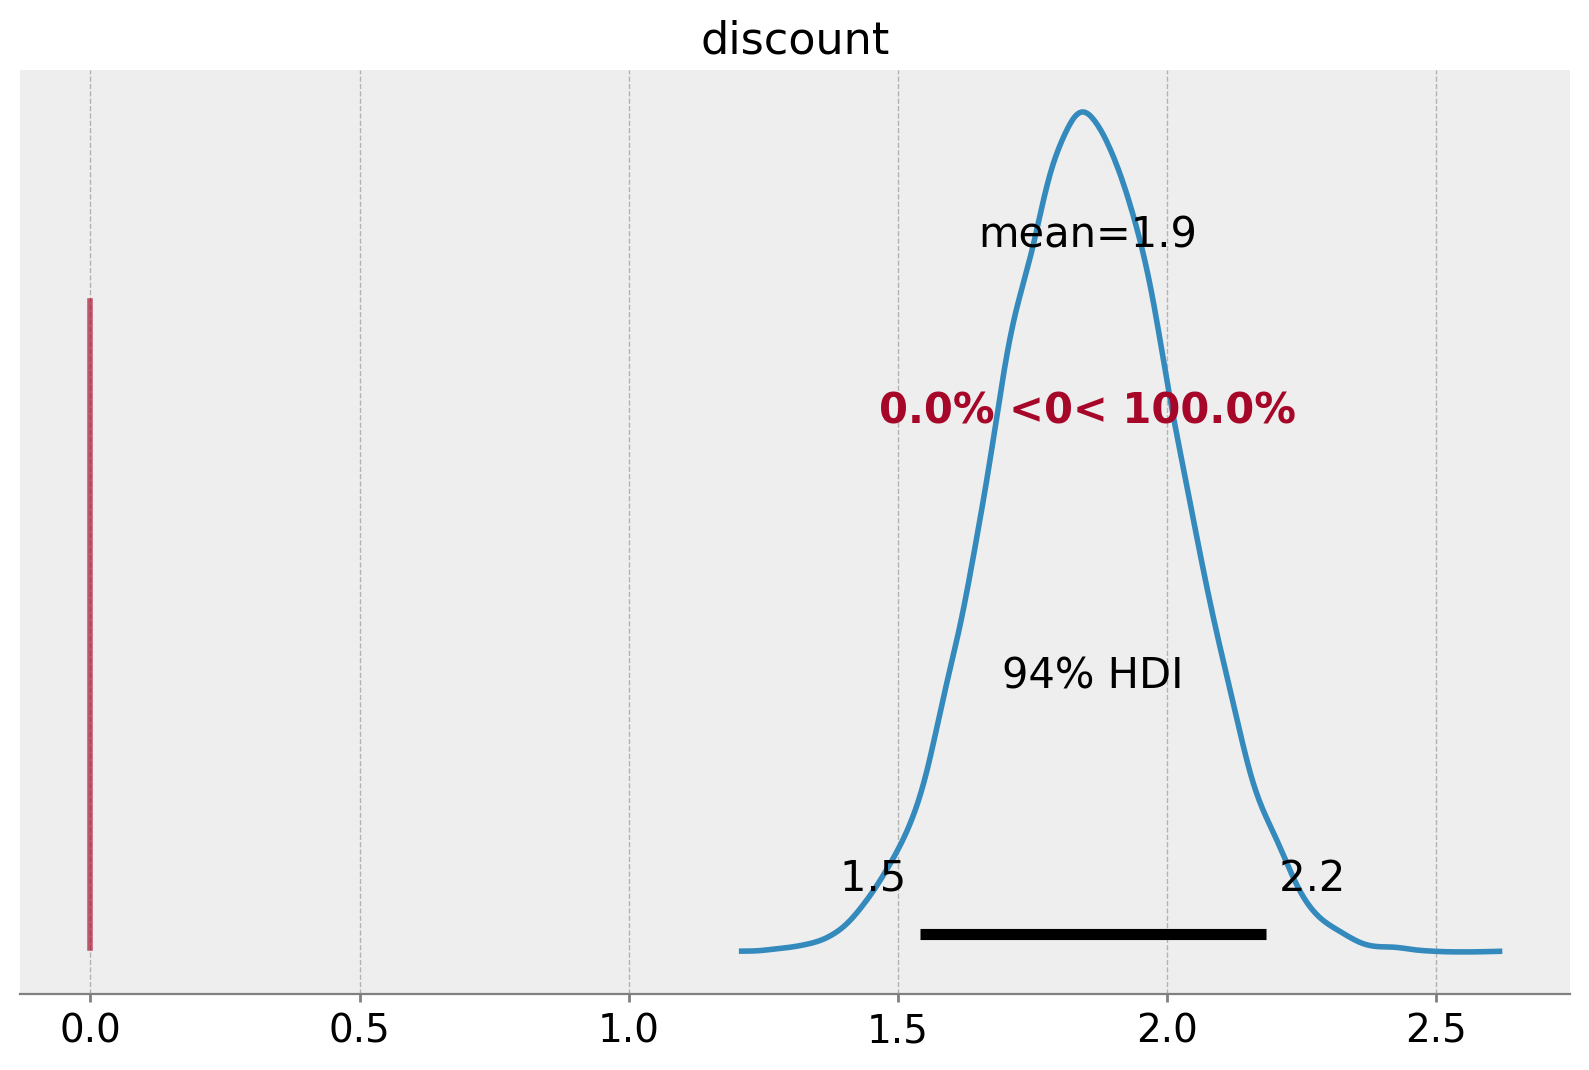

In [42]:
fig, ax = plt.subplots()
az.plot_posterior(data=causal_model_idata, var_names=["discount"], ref_val=0, ax=ax)


We see that the discount effect is now positive and the posterior predictive mean effect is around $2\$$ as expected!

### Posterior Predictive Checks

In [43]:
causal_model.predict(idata=causal_model_idata, kind="pps", inplace=True)

[Text(0.5, 1.0, 'Causal Model - Posterior Predictive')]

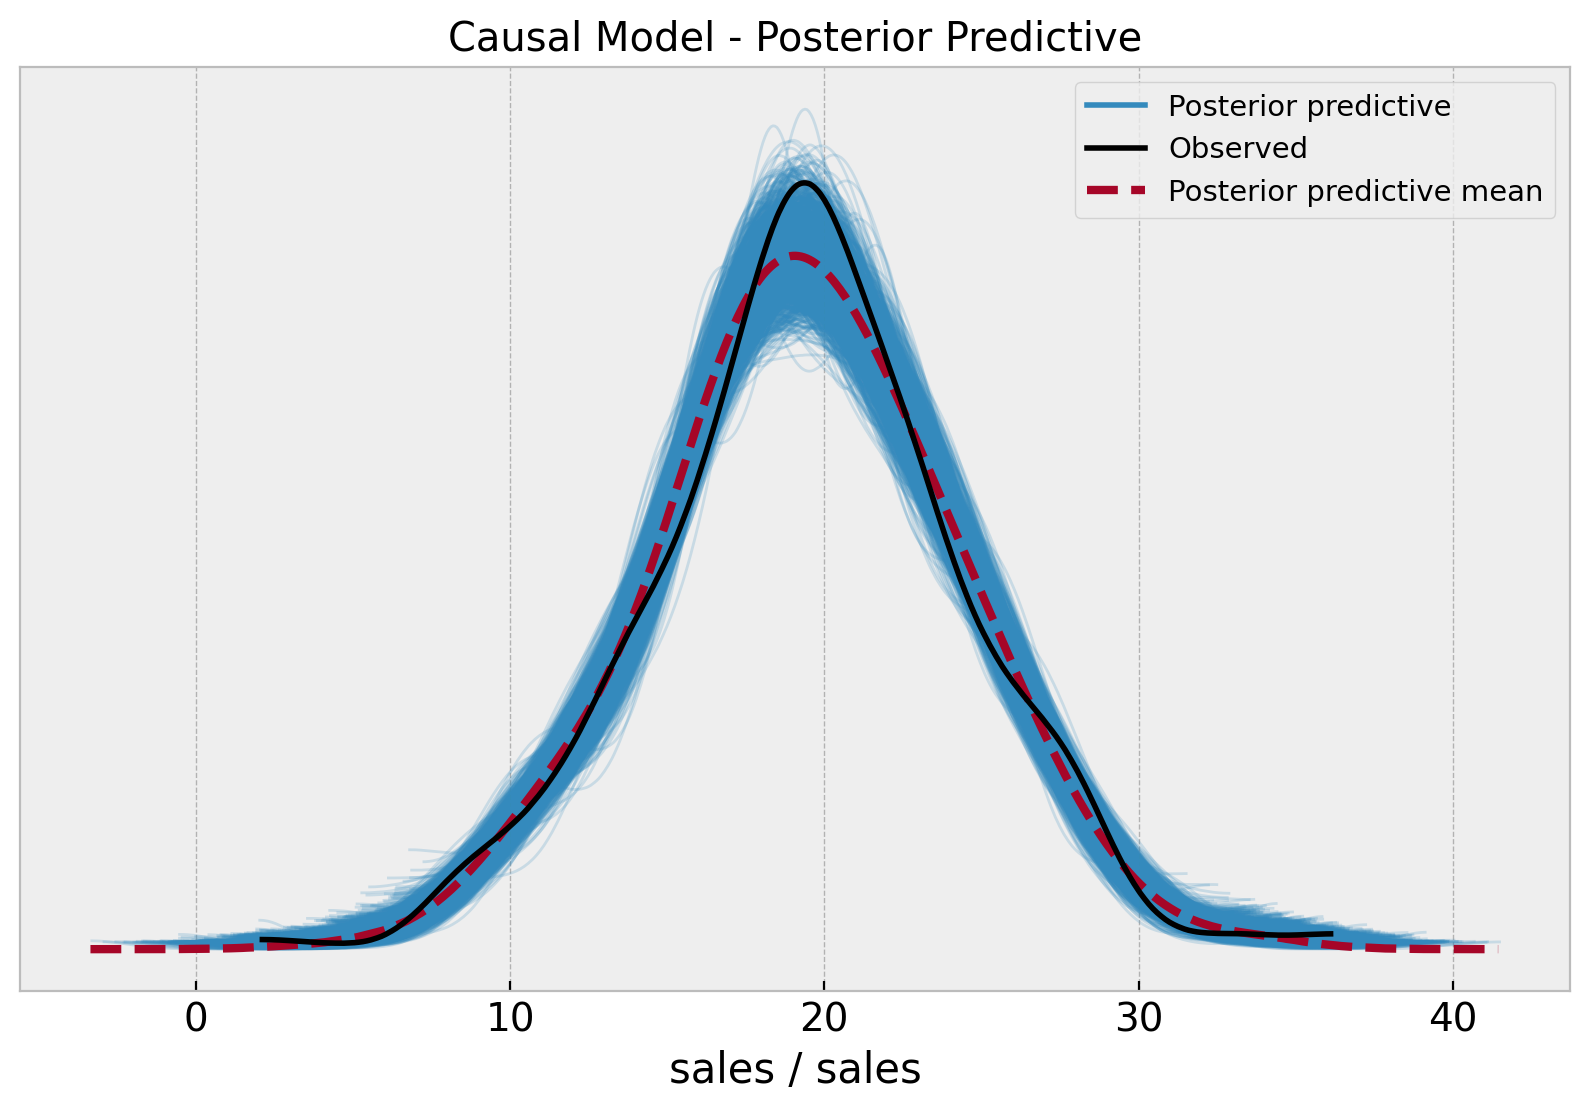

In [44]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=causal_model_idata,
    group="posterior",
    kind="kde",
    num_pp_samples=2_000,
    random_seed=seed,
    ax=ax,
)
ax.set(title="Causal Model - Posterior Predictive")

Note that removing the collider variable `is_loyal` from the model does not affect the posterior predictive fit.

## Discount Estimation Comparison

We can now compare the discount effect estimates from the complete (non-causal) linear model and the causal linear model.

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

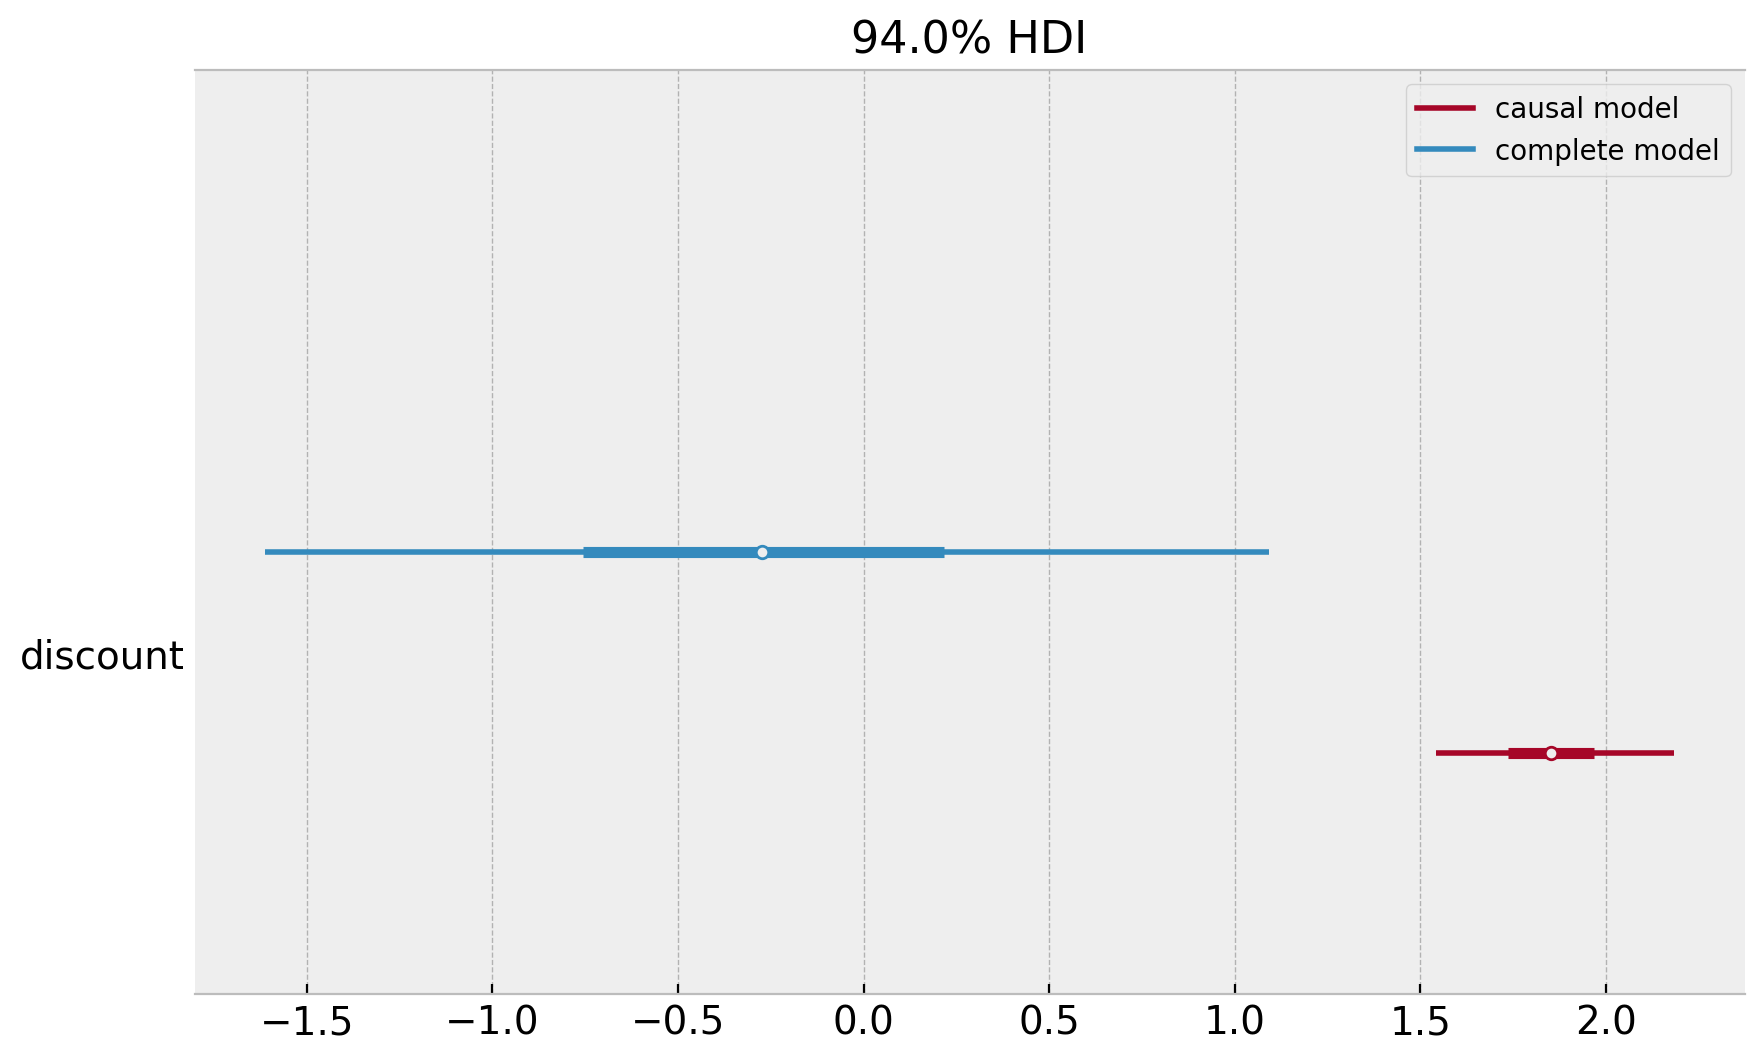

In [45]:
fig, ax = plt.subplots()


az.plot_forest(
    data=[complete_model_idata, causal_model_idata],
    var_names=["discount"],
    model_names=["complete model", "causal model"],
    combined=True,
    ax=ax,
)

Here we can appreciate the negative consequence of adding the bad control variable `is_loyal`. Moreover, observe that adding more features to the model does not translate to variance reduction!

## Learnings

Hopefully, this example shows the importance of understanding the data generating process and the assumptions behind it. In the example above, we saw how ignoring this aspect can lead to wrong conclusions which can actually hurt business decisions and potentially cost a lot of money. Here is a summary of the learnings:
- Understand the data generating process and the assumptions behind the causal relations (do not forget the potential unobservable variables, these can also create problems when ignored!).
- DAGs are a great tool for this.
- Adding all available features is generally not a good idea, specially for inference purposes.
- Nor simpler nor more complex models can save you from bad data understanding.
- Machine learning models are not always the solution for applied data science problems.
- Inference and prediction tasks are different (see [here](https://matheusfacure.github.io/python-causality-handbook/18-Heterogeneous-Treatment-Effects-and-Personalization.html) for another use case showing this).

## Appending A: Causal Inference Software

In this concrete example it was relatively easy to extract the subset of good control variables. In most complex cases (common in applications), this can be a very difficult task. Fortunately, there are some software packages which can help you with this task. Here I illustrate how to do it using the [`dowhy`](https://www.pywhy.org/dowhy/v0.9.1/) library (and the great book [Causal Inference and Discovery in Python: Unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more](https://www.amazon.de/dp/1804612987?utm_term=2023_06&utm_campaign=causalpython_links&utm_medium=button&ref_=as_li_ss_tl&language=en_US&utm_source=webpage&linkCode=gg2&linkId=842a3ff0187e800a338f20d3ce81352b&tag=alxndrmlk00-20)).

As a first step we need to specify the DAG in [gml format](https://gephi.org/users/supported-graph-formats/gml-format/).

In [46]:
gml_graph = """
graph [
    directed 1
    
    node [
        id "discount"
        label "discount"
    ]
    node [
        id "visits"
        label "visits"
    ]
    node [
        id "sales"
        label "sales"
    ]
    node [
        id "is_loyal"
        label "is_loyal"
    ]
    edge [
        source "discount"
        target "sales"
    ]
    edge [
        source "visits"
        target "discount"
    ]
    edge [
        source "visits"
        target "sales"
    ]
    edge [
        source "discount"
        target "is_loyal"
    ]
    edge [
        source "sales"
        target "is_loyal"
    ]
]
"""

Next, we can simply initialize the `CausalModel` object.

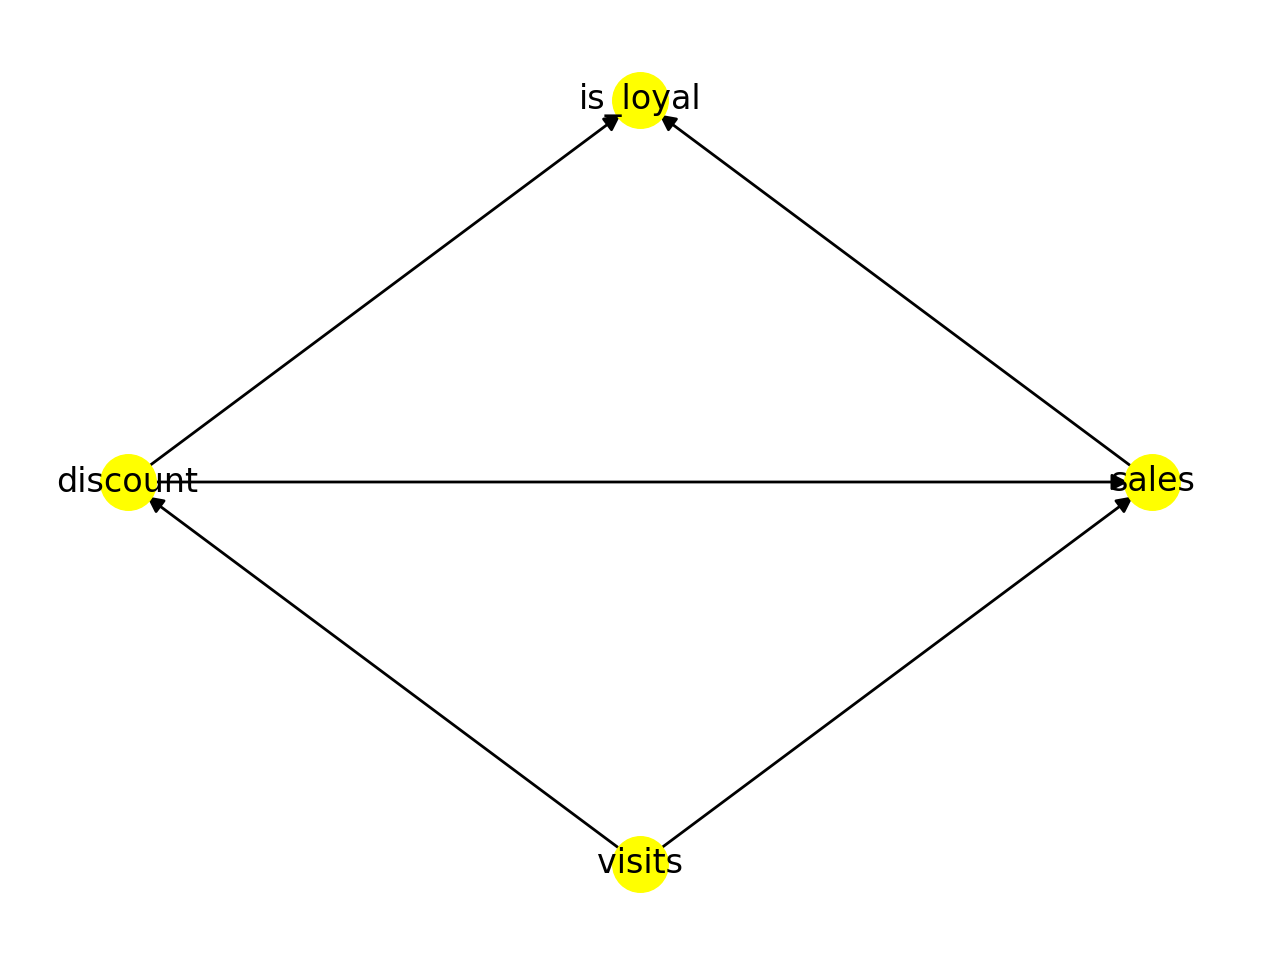

In [47]:
from dowhy import CausalModel

model = CausalModel(
    data=data,
    graph=gml_graph,
    treatment="discount",
    outcome="sales",
)

model.view_model()


DoWhy provides a rich set of mechanisms to estimate the causal effects. We can use the `identify_effect` method to get a list of the potential methods.

In [48]:
estimand = model.identify_effect()

print(estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                      
───────────(E[sales|visits])
d[discount]                 
Estimand assumption 1, Unconfoundedness: If U→{discount} and U→sales then P(sales|discount,visits,U) = P(sales|discount,visits)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In this case we will use the `backdoor` method. In essence, this method will use the backdoor criterion to identify the set of good control variables and then run a (linear) regression model to estimate the causal effect. Let's see how to get the list of good control variables we need to consider:

In [49]:
estimand.get_backdoor_variables()


['visits']

As expected, the `is_loyal` variable does not appear in the list.

Note that the backdoor criterion is a graph property. Hence, we can hack the API to access the graph attribute to obtain a rich set of methods to analyze it. For example, we can get all the valid backdoor paths:

In [50]:
model._graph.get_backdoor_paths(nodes1=["discount"], nodes2=["sales"])

[['discount', 'visits', 'sales']]

We can also check for valid control sets:

In [51]:
model._graph.check_valid_backdoor_set(nodes1=["discount"], nodes2=["sales"], nodes3=["visits"])

{'is_dseparated': True}

In [52]:
model._graph.check_valid_backdoor_set(nodes1=["discount"], nodes2=["sales"], nodes3=["is_loyal"])

{'is_dseparated': False}

After selecting the estimand, we can proceed to estimate the causal effect:

In [53]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.linear_regression",
    target_units="ate",
    test_significance=True,
    confidence_intervals=True,
)

print(f"Estimate of causal effect (linear regression): {estimate.value}")
print(f"confidence interval: {estimate.get_confidence_intervals()}")

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
Estimate of causal effect (linear regression): 1.855502783142704
confidence interval: [[1.51720297 2.1938026 ]]


The results are very similar to what we obtained with the linear Bayesian linear regression model above.


This library allow us to challenge the graph structure using the data though a family of *refuters*. See [Refute the obtained estimate](https://www.pywhy.org/dowhy/v0.8/user_guide/effect_inference/refute.html) from the documentation for more details. For example, we can use the *data subset* refuter to check if the causal effect is robust when estimating it on a subset of the data:

In [54]:
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.7,
    random_state=rng,
    verbose=0,
)

print(refute_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

We do see that the causal effect is stable to the data subset.

We can also add a common cause variable (for both the treatment and the target). The results should not change:

In [55]:
refute_random_common_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="random_common_cause",
    random_state=rng,
    verbose=0,
)

print(refute_random_common_cause)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

The results are indeed the same.

Please look into the the [`dowhy`](https://www.pywhy.org/dowhy/v0.9.1/) documentation for more details and examples.

## Appendix B: ML Model

Here we revisit the machine learning model approach with the right set of features.

[Text(0.5, 1.0, 'ML Model (Causal) - Partial Dependence Plot (Centered)')]

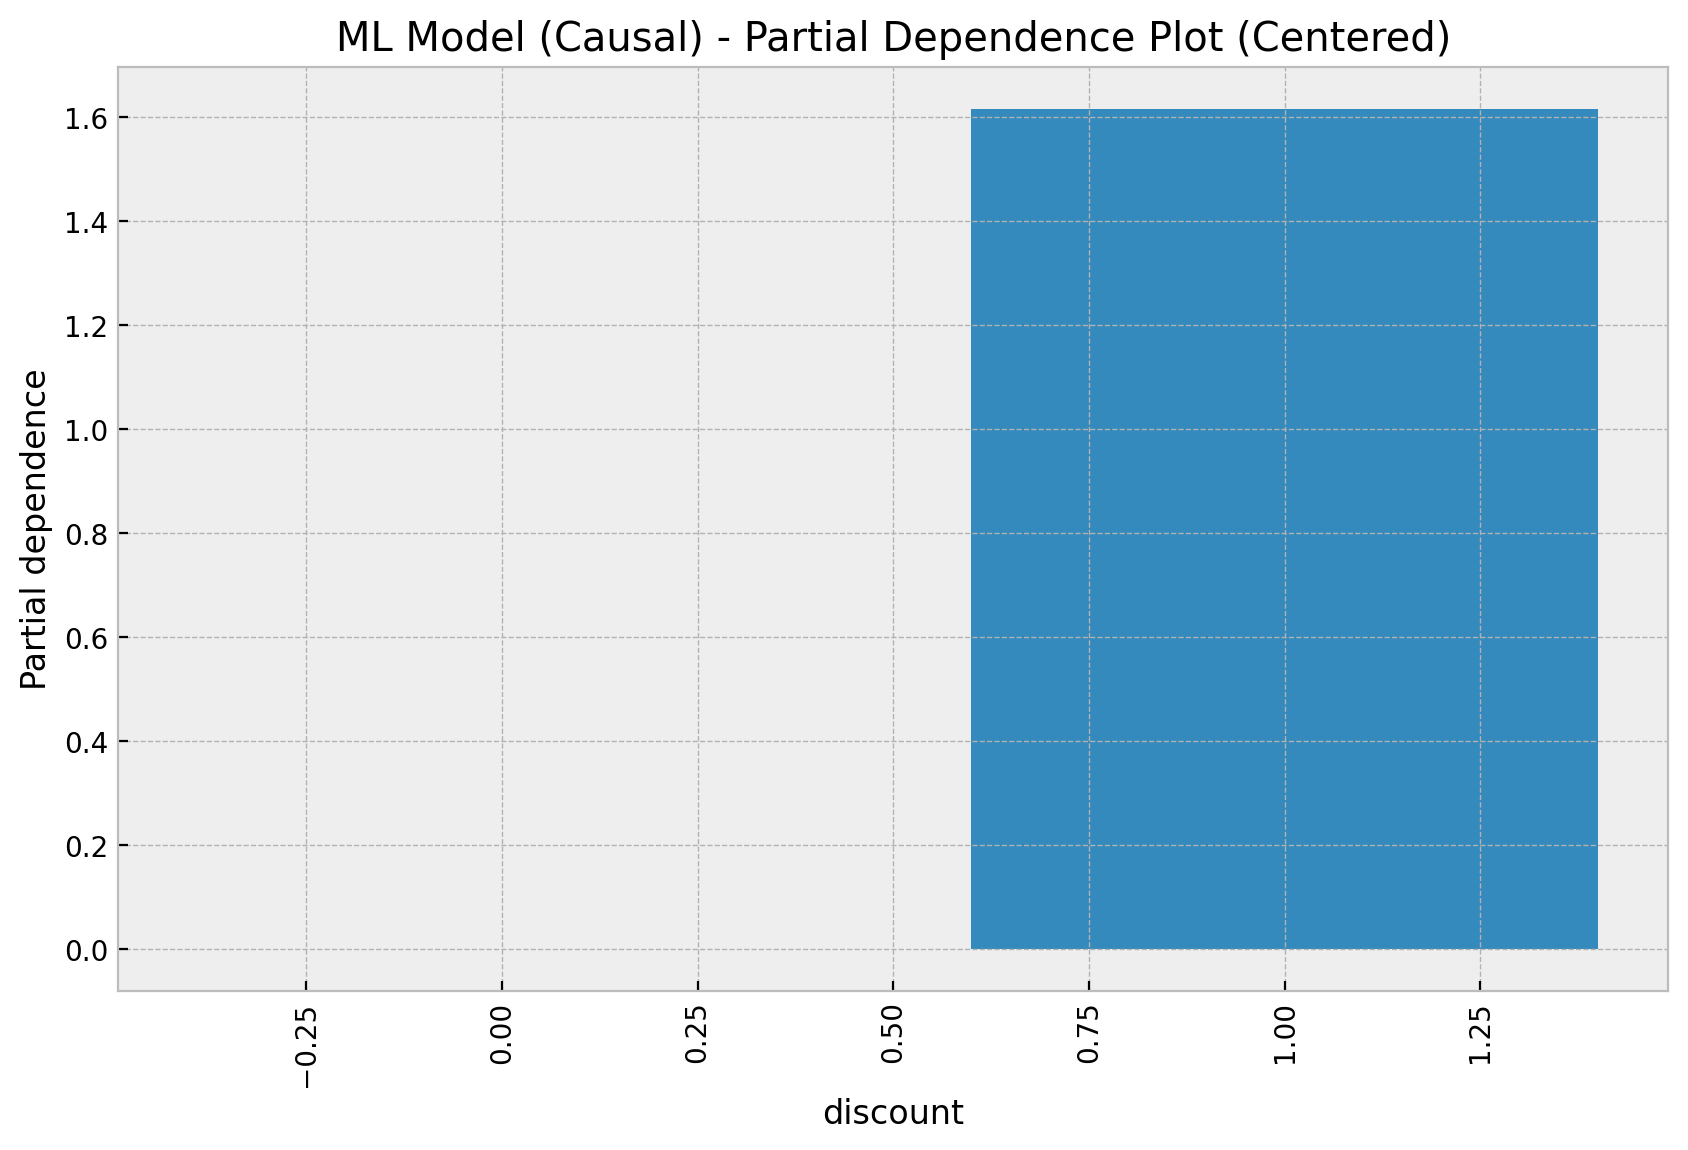

In [56]:
X_causal = X.drop(columns=["is_loyal"])

ml_model.fit(X=X_causal, y=y)

fig, ax = plt.subplots()

PartialDependenceDisplay.from_estimator(
    estimator=ml_model,
    X=X_causal,
    features=["discount"],
    categorical_features=["discount"],
    centered=True,
    random_state=seed,
    ax=ax,
)
ax.set(title="ML Model (Causal) - Partial Dependence Plot (Centered)")

The result is much closer that the complete model. Note however that estimated effect through partial dependency plots is below the true effect. This is  might because there there is a relationship between the `discount` and `visits` variable. This will induce non-realistic points to be evaluated during the marginalization. This is a common problem with partial dependency plots. In general, I do not recommend using them for causal inference purposes. I recommend to use them for post-processing/understanding of purely predictions models (acknowledging their limitations).

## References

Here are some references which I have found useful to learn about causal inference:

### Causal Inference

- [Causal Inference and Discovery in Python: Unlock the secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more](https://www.amazon.de/dp/1804612987?utm_term=2023_06&utm_campaign=causalpython_links&utm_medium=button&ref_=as_li_ss_tl&language=en_US&utm_source=webpage&linkCode=gg2&linkId=842a3ff0187e800a338f20d3ce81352b&tag=alxndrmlk00-20)
- [Causal Inference in Statistics: A Primer](https://www.wiley.com/en-us/Causal+Inference+in+Statistics%3A+A+Primer-p-9781119186847)
- [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)
- [Causal Inference: The Mixtape](https://mixtape.scunning.com/index.html)
- [Statistical Rethinking: A Bayesian Course with Examples in R and Stan](https://xcelab.net/rm/statistical-rethinking/)
- [The Effect: An Introduction to Research Design and Causality](https://theeffectbook.net/)

### Interpretable Machine Learning

- [Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)
- [Exploring Tools for Interpretable Machine Learning](https://juanitorduz.github.io/interpretable_ml/)

## Acknowledgements

I would like to thank [Dr. Eva Martinez Romero](https://www.linkedin.com/in/emartiro/) for helping me design the analytics use case and revising the notebook.